In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="" 

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import cross_validate

import copy

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
from matplotlib.patches import PathPatch

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statistics
import os
from scipy.stats import shapiro
from scipy.stats import norm
import statistics
import keras

Using TensorFlow backend.


In [3]:
# Import the data
dataset = pd.read_excel('data\\data.xlsx',sheet_name='data')

In [4]:
# Remove the outlier sample with the biggest porosity

placesConsidered = ["Pedreira_Sal","Cachoeira_do_Roncador"]
isOneOfThePlaces = lambda x: x in placesConsidered
vectorIsOneOfThePlaces = np.vectorize(isOneOfThePlaces)
filteredDataFrame = dataset[vectorIsOneOfThePlaces(dataset['place'])]

In [5]:
workingDF = filteredDataFrame.groupby(["sample","place"]).mean()
workingDF.reset_index(level=["sample","place"], inplace=True)
workingDF.head()

,sample,place,seq,344.3,345.9,347.4,349,350.6,352.2,353.8,...,2485.8,2487.9,2490.1,2492.3,2494.4,2496.6,2498.8,2500.9,2503.1,Porosity (%)
0,CR_19_001b,Cachoeira_do_Roncador,0,1,0.960840,0.929212,0.884990,0.870946,0.877854,0.855160,...,0.967578,0.974678,0.982242,0.980688,0.969338,0.965074,0.977764,0.989552,1,21.92
1,CR_19_002b,Cachoeira_do_Roncador,1,1,0.963522,0.947540,0.927332,0.911990,0.888304,0.900208,...,0.982074,0.982646,0.984870,0.988154,0.987644,0.986576,0.985368,0.990036,1,19.52
2,CR_19_004a,Cachoeira_do_Roncador,2,1,0.968920,0.941636,0.917628,0.898952,0.894568,0.885722,...,0.977986,0.982782,0.985580,0.985090,0.981198,0.981110,0.987048,0.992854,1,18.47
3,CR_19_005a,Cachoeira_do_Roncador,3,1,0.974592,0.938760,0.920144,0.913816,0.895142,0.896628,...,0.983364,0.986168,0.989414,0.987708,0.983966,0.984120,0.987396,0.993000,1,19.10
4,CR_19_006a,Cachoeira_do_Roncador,4,1,0.964072,0.928596,0.916218,0.899484,0.878728,0.882806,...,0.973980,0.979038,0.985570,0.987002,0.976900,0.974518,0.981468,0.987840,1,20.39


In [6]:
# Resample the dataset

dfRoncador = workingDF[workingDF['place'] == 'Cachoeira_do_Roncador']
dfPedreiraSal = workingDF[workingDF['place'] == 'Pedreira_Sal']  
nSamplesPedreiraSal = min(int(len(dfRoncador) * 2.5 //10),
                                len(dfPedreiraSal))
dfPedreiraSal = dfPedreiraSal.sample(n=nSamplesPedreiraSal, replace=False, random_state=1)

workingDF = pd.concat([dfPedreiraSal,dfRoncador]).reset_index()
workingDF = workingDF.drop(columns='index')    
    
XComplete = workingDF.values[:,-969:-51].astype(np.float64)
YComplete = workingDF['Porosity (%)'].values.astype(np.float64)

In [7]:
YComplete

array([ 0.797,  0.824,  2.423, 21.92 , 19.52 , 18.47 , 19.1  , 20.39 ,
       18.01 , 12.88 , 11.43 ,  4.22 , 21.1  ,  5.88 ,  6.07 ])

In [8]:
# Dataset Normalization

mmX = MinMaxScaler()
mmY = MinMaxScaler()

XComplete = mmX.fit_transform(XComplete)
YComplete = mmY.fit_transform(YComplete.reshape(-1,1))

finalDataFrame = pd.DataFrame(XComplete)#,columns = myColumns)
finalDataFrame['place'] = workingDF['place']
finalDataFrame['poro'] = workingDF['Porosity (%)']

featureColumns = list(finalDataFrame.keys()[:-2])

In [9]:
# Auxiliary Functions
upper_scores = None
def getKfoldIndexes():
  return copy.deepcopy(kfold_indexes)

def evaluateModel(model, modelName, saveBandImportances = False):
    global upper_scores
    scores = cross_validate(model, 
                            XComplete, 
                            y = np.ravel(YComplete),
                            cv=getKfoldIndexes(), 
                            scoring = {'mse': 'neg_mean_squared_error'},
                            return_estimator=True)
    upper_scores = scores
    #print('R2:',scores['test_r2'])
    print(modelName,'MSE',scores['test_mse'])
    generateGraphs(scores,modelName)
    if saveBandImportances:
        bandsImportance(scores['estimator'], modelName)
    
    return scores

def bandsImportance(estimatorsList, modelName):
    colunasComImportancia = filteredDataFrame.columns[58:-51].values
    importanceList = []
    
    cross_val_indexes = getKfoldIndexes()
    
    acumImportance = np.array([0]*918)
    foldCountIndex = 0
    for est, foldsSeparation in list(zip(estimatorsList,
                                         cross_val_indexes)):
        foldTrain, foldTest = foldsSeparation
        yFold = YComplete[foldTrain]
        xFold = XComplete[foldTrain]
        foldCountIndex = foldCountIndex + 1
        
        result = permutation_importance(est, xFold, yFold, n_repeats=10,
                                        random_state=0)
        print('Processing Fold:', foldCountIndex)
        acumImportance = acumImportance + result.importances_mean  
    
    acumImportance = list(map(lambda x: x/10, acumImportance))
    colunaZip = list(zip(colunasComImportancia, acumImportance))
    colunaZip = sorted(colunaZip, reverse=True, key=lambda x:x[1])
    with open('BandImportances' + modelName+'.txt', 'w') as file_object:
        file_object.write("Band;Importance\n")
        for bandImportance, importanceValue in colunaZip:
            file_object.write(str(bandImportance) + ";" + str(importanceValue) + "\n")

In [10]:
# ML Preparation
listSamples = workingDF.groupby(["sample","place"]).mean()#.values[:,3:-1].astype(np.float64)
listSamples.reset_index(level=["sample","place"], inplace=True)    
listSamples = list(listSamples['sample'].values)

n_split = len(XComplete)

    

dictSampleIndexes = {}
for i in range(len(listSamples)):
    dictSampleIndexes[i] = list(workingDF[workingDF['sample'] == listSamples[i]].index)
    
kfold_indexes = list(KFold(n_split,shuffle=True).split(listSamples))

newKfoldIndexes = []

for train_fold, test_fold in kfold_indexes:
    listTrainFold = list(map(lambda x: dictSampleIndexes[x],train_fold))
    flatListTrain = [item for sublist in listTrainFold for item in sublist]
    
    listTestFold = list(map(lambda x: dictSampleIndexes[x],test_fold))
    flatListTest = [item for sublist in listTestFold for item in sublist]
    newKfoldIndexes.append((flatListTrain,flatListTest))
kfold_indexes = newKfoldIndexes


In [11]:
# Error estimation plots

def generateGraphs(crosValidScores,modelName):
  resultList = crosValidScores['estimator']
  varia = 0
  cross_val_indexes = getKfoldIndexes()
  plt.style.use(['seaborn-ticks'])
  meanSquaredErrorsList = []
  listYhat = []
  listY = []
  for est in resultList:
    x_temp = cross_val_indexes[varia][1]
    if len(x_temp) > 0:
        ground_truth = YComplete[x_temp]
        x_temp = XComplete[x_temp]
        pred = est.predict(x_temp)
        listYhat = listYhat + list(pred)
        listY = listY + list(ground_truth.reshape(1,-1)[0])
        meanSquaredErrorsList.append(mean_squared_error(pred,
                                                        ground_truth.reshape(1,-1)[0]))
    else:
        print('Problem')
    varia = varia + 1

  plt.plot(listY, listYhat,"o")
  plt.plot([0, 1], [0, 1], 'k-')
  linear = LinearRegression()

  yArray = np.asarray(listY).reshape(len(listY),1)
  yHatArray = np.asarray(listYhat).reshape(len(listYhat),1)
  linear.fit(yArray,yHatArray)
  plt.plot(yArray, linear.predict(yArray),'k-', color='red')
 
    
  plt.xlabel('True Porosity')
  plt.ylabel(modelName+' Estimated Porosity')

  r2Result = r2_score(listY,listYhat)
  print("R2:", r2Result)
  print("MSE:", meanSquaredErrorsList)
  
  trueMSE = statistics.mean(meanSquaredErrorsList)
  print('mean:', trueMSE)
  print('std:',statistics.stdev(meanSquaredErrorsList))
  plt.text(0, 0.92, 'R2: '+ str(round(r2Result,4)) + '\nMSE: '+ str(round(trueMSE,6)), bbox=dict(facecolor='gray', alpha=0.5))
  plt.title(modelName)
  plt.grid(True)

  plt.show()
  

  errorsList = list(map(lambda x: x[0] - x[1], zip(listY,listYhat)))
  #extimateError(modelName, 
  #              'residual error', 
  #              errorsList,
  #              binsUse = [-.55,-.45,-.35,-.25,-.15,-.05,
  #                      .05,.15,.25,.35,.45,.55],
  #              normalFit=True)
  #
  #extimateError(modelName, 'MSE', meanSquaredErrorsList)

def extimateError(modelName, 
                  graphName, 
                  errorsList, 
                  binsUse = 10,
                  normalFit = False):
    
    
    # Fit a normal distribution to the data:
    
    plt.hist(errorsList, bins = binsUse, density=True)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    titleGraph = modelName + " " + graphName
    plt.title(titleGraph)
    if normalFit:
        
        shapTest = shapiro(errorsList)
        
        mu, std = norm.fit(errorsList)
        xGraph = np.linspace(xmin, xmax, 100)
        p = norm.pdf(xGraph, mu, std)
        plt.plot(xGraph, p, 'k', linewidth=2)
        textGraph = "Fit results: \nmu = %.2f \nstd = %.2f \nShapiro: %.4f \npval: %s" % (mu, std, shapTest[0], ('%.2E' if shapTest[1] < 0.0001 else '%.6f') % shapTest[1])
        plt.text(xmin,
                 ymax * 0.95, 
                 textGraph, 
                 bbox=dict(facecolor='gray', alpha=0.5),
                 horizontalalignment='left',
                 verticalalignment='top')
        print('Normal Fit\nShapiro:',
              shapTest[0],
              'pval:',
              shapTest[1])
    plt.grid()
    plt.show()


Linear Reg MSE [-3.31159648e-02 -5.01296005e-03 -5.91563088e-04 -3.80704522e-03
 -3.00388924e-04 -3.85998010e-03 -1.33857201e+00 -3.13273951e-04
 -4.58547376e-03 -1.47597098e-02 -1.26730311e-02 -8.84823957e-02
 -5.19810754e-04 -1.15504535e-02 -2.21767024e-03]
R2: 0.25644246199414433
MSE: [0.03311596481481052, 0.005012960053984088, 0.0005915630878604944, 0.003807045219596402, 0.0003003889238445901, 0.003859980103229791, 1.33857201328705, 0.00031327395095402774, 0.004585473759499108, 0.014759709841551519, 0.01267303112282154, 0.08848239573521358, 0.000519810754057136, 0.011550453504926396, 0.0022176702395522085]
mean: 0.1013574489599301
std: 0.3430112444047076


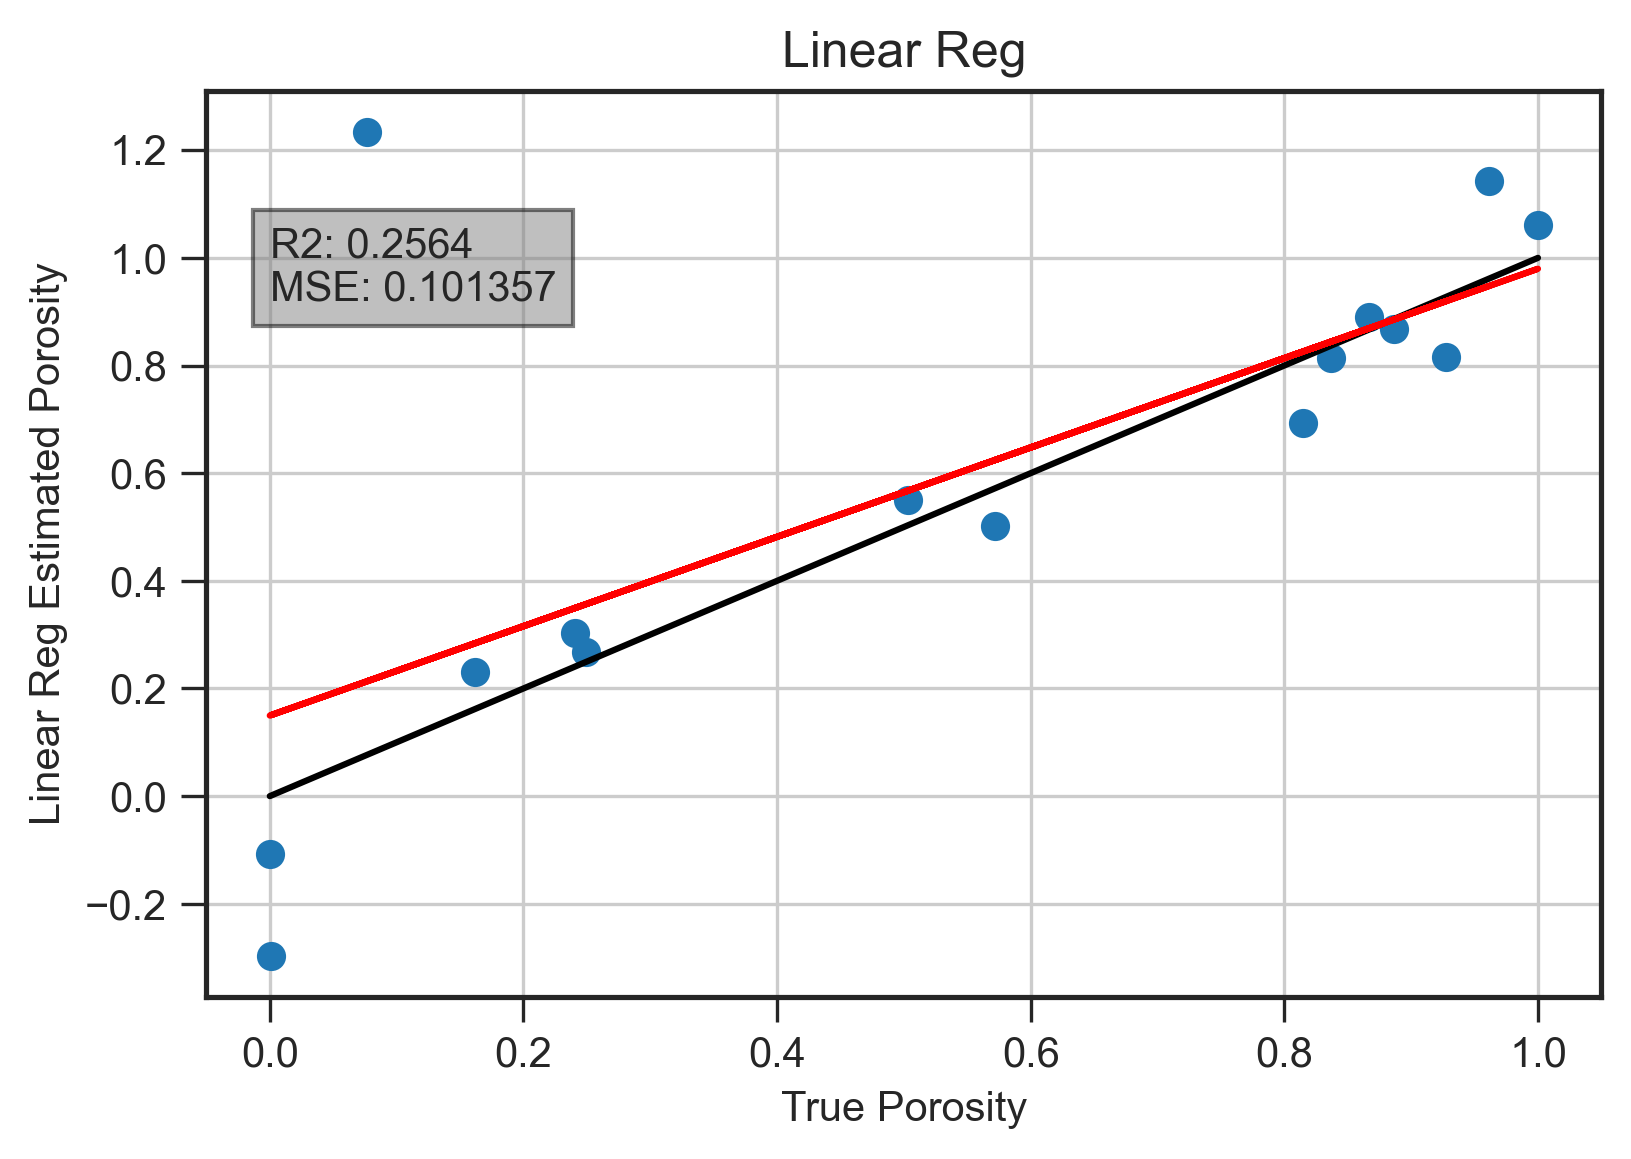

{'fit_time': array([0.85510159, 0.00100017, 0.00100112, 0.00099945, 0.00099969,
        0.0010004 , 0.00100017, 0.00099969, 0.00100017, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'score_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00099993, 0.00100064, 0.00099969]),
 'estimator': [LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression()],
 'test_mse': array([-3.31159648e-02, -5.01296005e-03, -5.91563088e-04, -3.80704522e-03,
        -3.00388924e-04, -3.85998010e-03, -1.33857201e+00, -3.13273951e-04,
        -4.58547376e-03, -1.47597098e-02, -1.26730311e

In [12]:
# Linear Regression
linear = LinearRegression()
evaluateModel(linear,'Linear Reg')

SVR MSE [-0.00035814 -0.00099825 -0.00207637 -0.00955366 -0.01352722 -0.03284131
 -0.10055018 -0.02915993 -0.03989621 -0.01584728 -0.00634044 -0.02982625
 -0.00346623 -0.09419437 -0.02217042]
R2: 0.8039792076752272
MSE: [0.00035814266926855473, 0.0009982476063296916, 0.002076374116649125, 0.009553658148686967, 0.013527217889771452, 0.03284131236218617, 0.10055017935331895, 0.029159931038446378, 0.039896205041603246, 0.015847281183191952, 0.0063404372722421455, 0.0298262454510911, 0.0034662290035115603, 0.0941943724072721, 0.022170420934616325]
mean: 0.026720416965212383
std: 0.0313482141949133


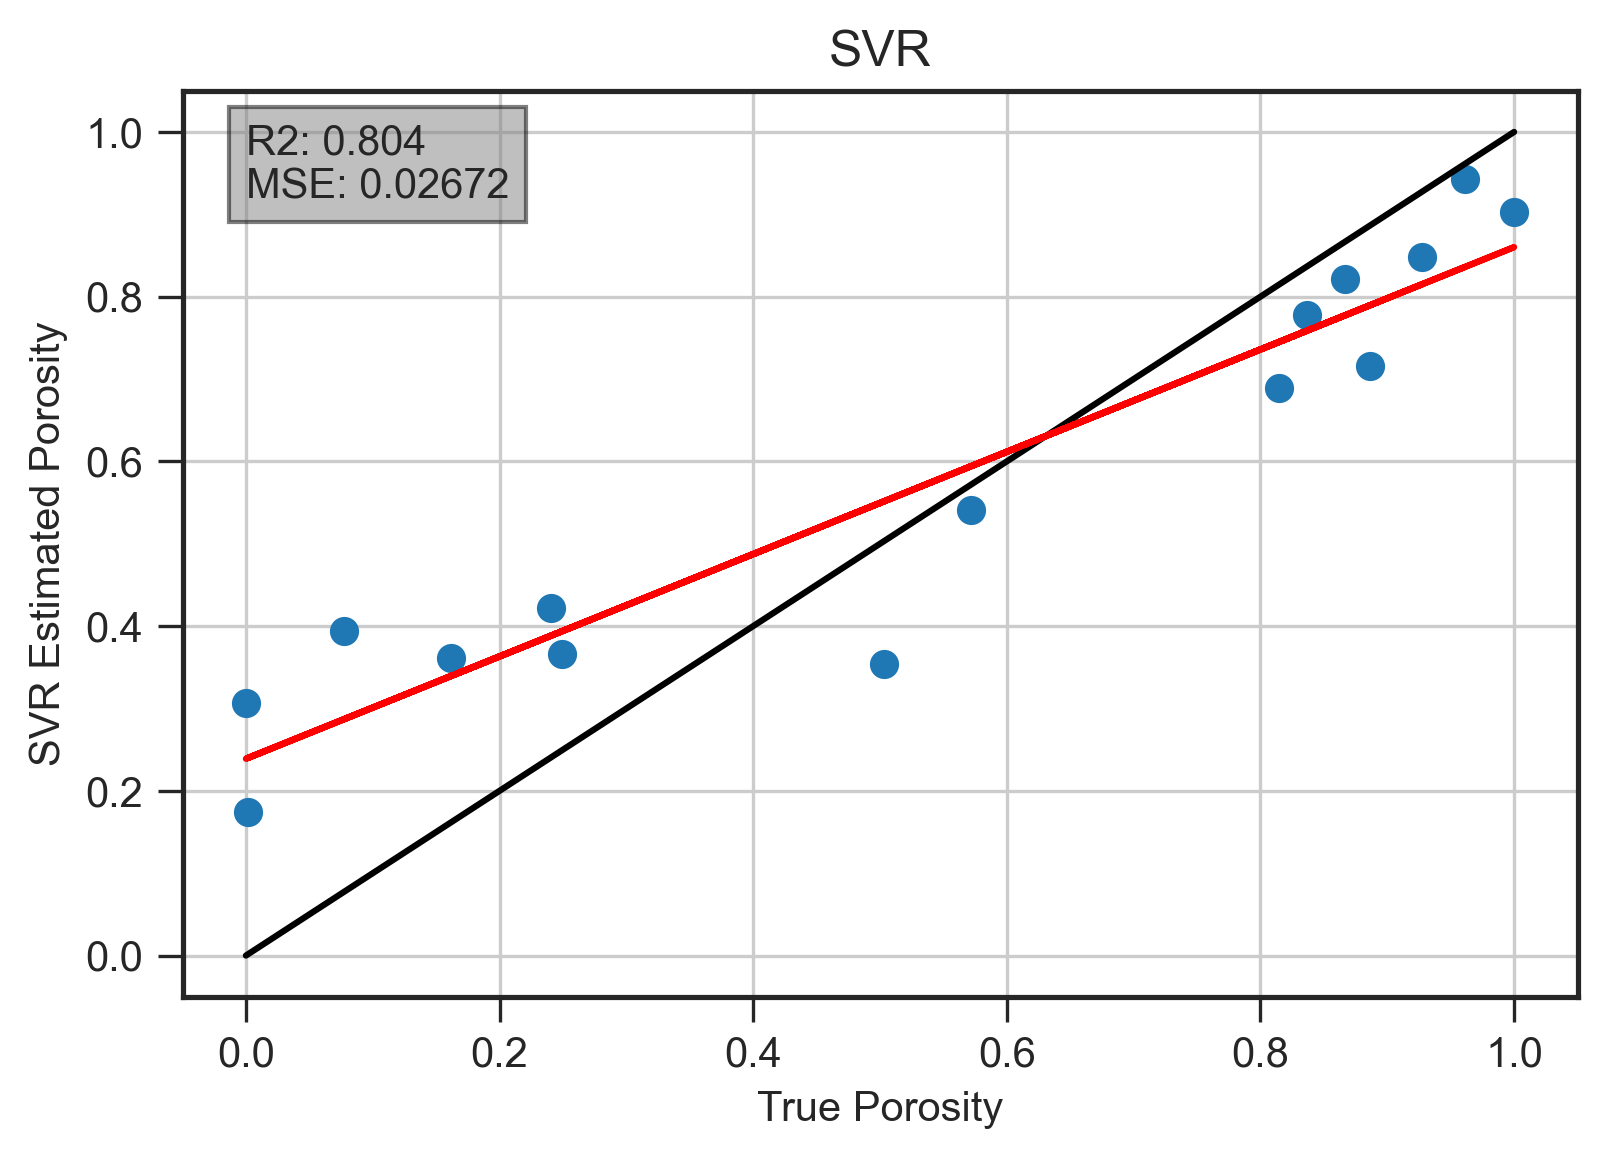

{'fit_time': array([0.05783963, 0.00102639, 0.00099587, 0.00096273, 0.00100112,
        0.00108457, 0.00095439, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00099707]),
 'score_time': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00099707, 0.00100064, 0.00099969,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'estimator': [SVR(epsilon=0.05),
  SVR(epsilon=0.05),
  SVR(epsilon=0.05),
  SVR(epsilon=0.05),
  SVR(epsilon=0.05),
  SVR(epsilon=0.05),
  SVR(epsilon=0.05),
  SVR(epsilon=0.05),
  SVR(epsilon=0.05),
  SVR(epsilon=0.05),
  SVR(epsilon=0.05),
  SVR(epsilon=0.05),
  SVR(epsilon=0.05),
  SVR(epsilon=0.05),
  SVR(epsilon=0.05)],
 'test_mse': array([-0.00035814, -0.00099825, -0.00207637, -0.00955366, -0.01352722,
        -0.03284131, -0.10055018, -0.02915993, -0.03989621, -0.01584728,
        -0.00634044, -0.02982625, -0.00346623, -0.09419437, -0.02217042])}

In [13]:
# SVR Model Evaluation
svr = SVR(gamma='scale', C=1.0, epsilon=0.05)
evaluateModel(svr, 'SVR', saveBandImportances=False)

KNN MSE [-8.89549051e-04 -4.02921568e-02 -2.90464996e-04 -9.75876722e-03
 -2.74487429e-03 -4.14540168e-03 -1.34036248e-05 -5.54349856e-02
 -2.86177749e-02 -5.45468560e-02 -5.07100733e-02 -1.21242297e-01
 -3.22738885e-03 -1.19456907e-02 -8.17641035e-02]
R2: 0.7722791429955144
MSE: [0.0008895490512778983, 0.040292156775642435, 0.0002904649963356673, 0.00975876722427999, 0.0027448742932181442, 0.0041454016760983405, 1.3403624796610266e-05, 0.055434985562655414, 0.028617774892741605, 0.054546855964806934, 0.05071007334731599, 0.12124229709410352, 0.003227388848172891, 0.011945690732648328, 0.08176410347466928]
mean: 0.03104158583725087
std: 0.036122460058246667


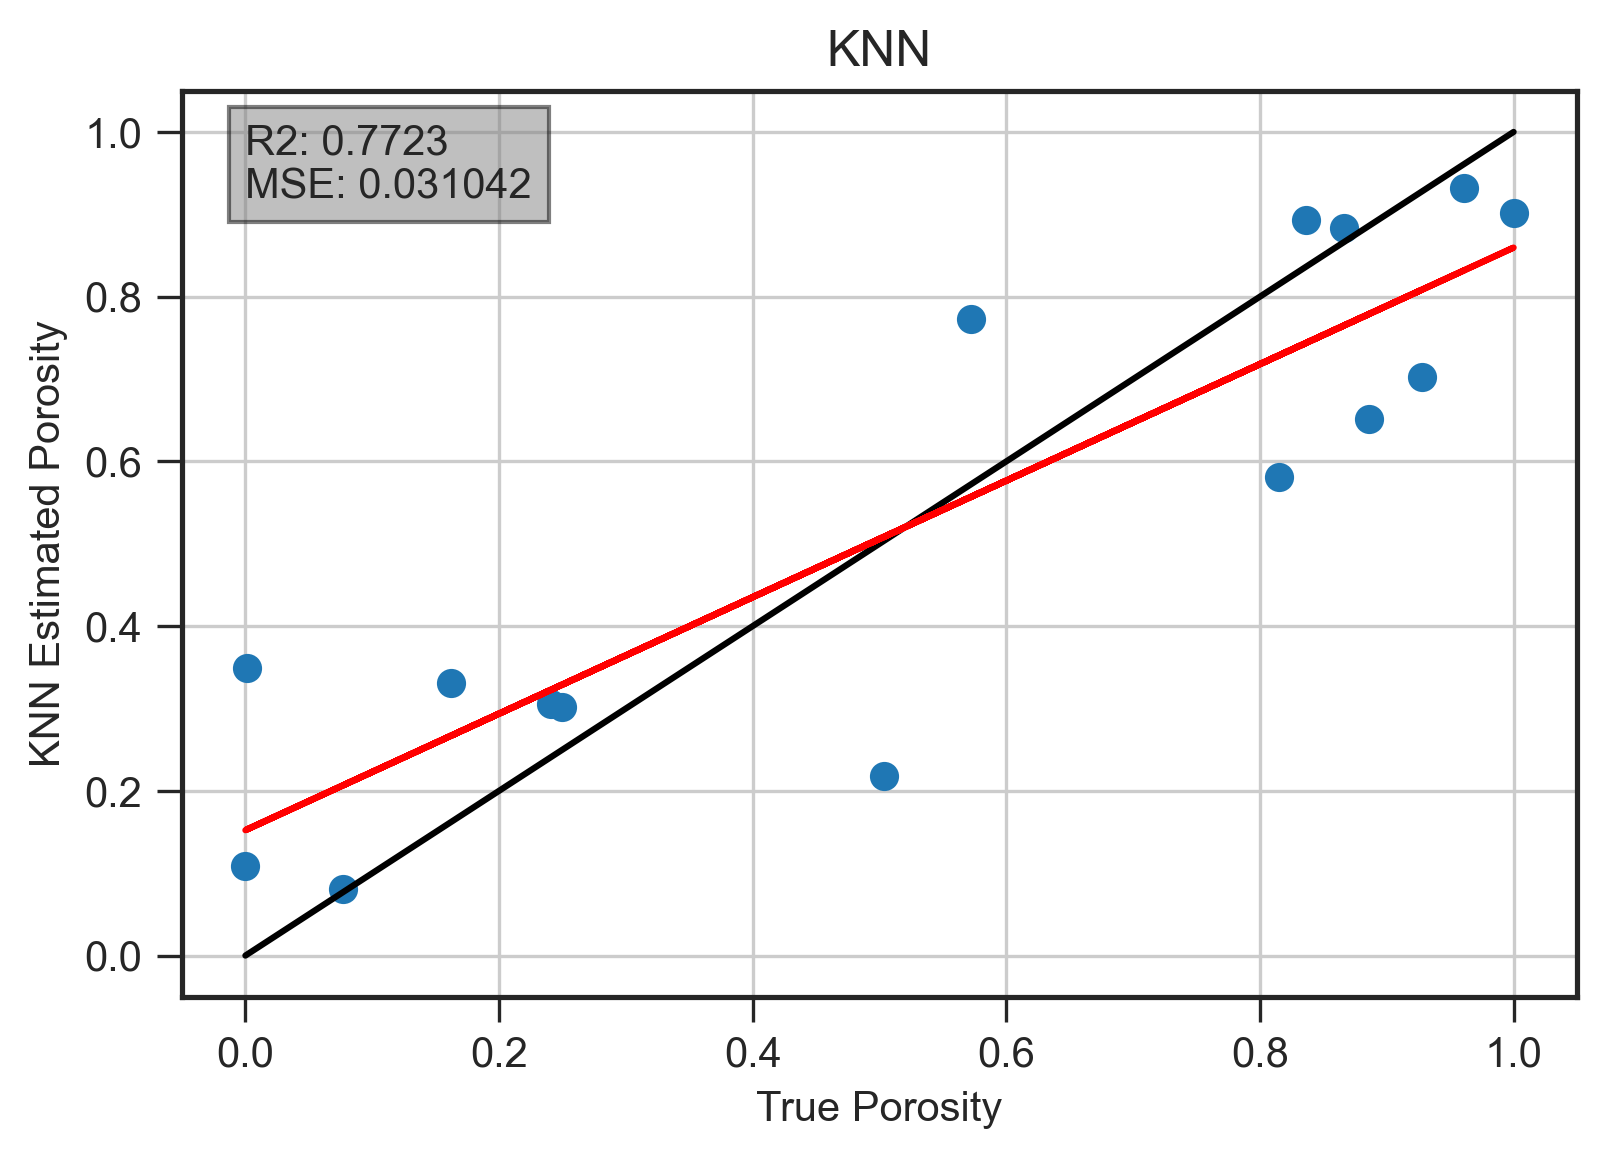

{'fit_time': array([0.00099301, 0.        , 0.00099945, 0.        , 0.        ,
        0.        , 0.00103831, 0.00100112, 0.00096035, 0.00103736,
        0.00100207, 0.        , 0.        , 0.00099921, 0.        ]),
 'score_time': array([0.00200033, 0.00100064, 0.00100183, 0.00099683, 0.00103831,
        0.00096273, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00099897, 0.00103927, 0.        , 0.        ]),
 'estimator': [KNeighborsRegressor(n_neighbors=3),
  KNeighborsRegressor(n_neighbors=3),
  KNeighborsRegressor(n_neighbors=3),
  KNeighborsRegressor(n_neighbors=3),
  KNeighborsRegressor(n_neighbors=3),
  KNeighborsRegressor(n_neighbors=3),
  KNeighborsRegressor(n_neighbors=3),
  KNeighborsRegressor(n_neighbors=3),
  KNeighborsRegressor(n_neighbors=3),
  KNeighborsRegressor(n_neighbors=3),
  KNeighborsRegressor(n_neighbors=3),
  KNeighborsRegressor(n_neighbors=3),
  KNeighborsRegressor(n_neighbors=3),
  KNeighborsRegressor(n_neighbors=3),
  KNeighborsRegre

In [14]:
# KNN Model Evaluation
knn = KNeighborsRegressor(n_neighbors=3)
evaluateModel(knn,'KNN', saveBandImportances=False)

RF MSE [-4.20658759e-05 -2.47932404e-02 -8.50452821e-04 -1.93197234e-02
 -3.67256769e-02 -2.64449217e-02 -8.20893167e-04 -7.92815820e-02
 -9.14573507e-02 -2.64141360e-02 -1.91621192e-02 -2.82198008e-02
 -2.23801487e-04 -2.34203154e-02 -1.26207243e-02]
R2: 0.8093635577650765
MSE: [4.206587589680694e-05, 0.02479324041515195, 0.0008504528213697136, 0.019319723403182224, 0.03672567693915171, 0.02644492165422812, 0.0008208931669093577, 0.07928158198730044, 0.09145735072089961, 0.02641413595060455, 0.019162119247763936, 0.028219800752712146, 0.00022380148668291045, 0.023420315384965952, 0.012620724261961695]
mean: 0.02598645360458541
std: 0.026895483930805576


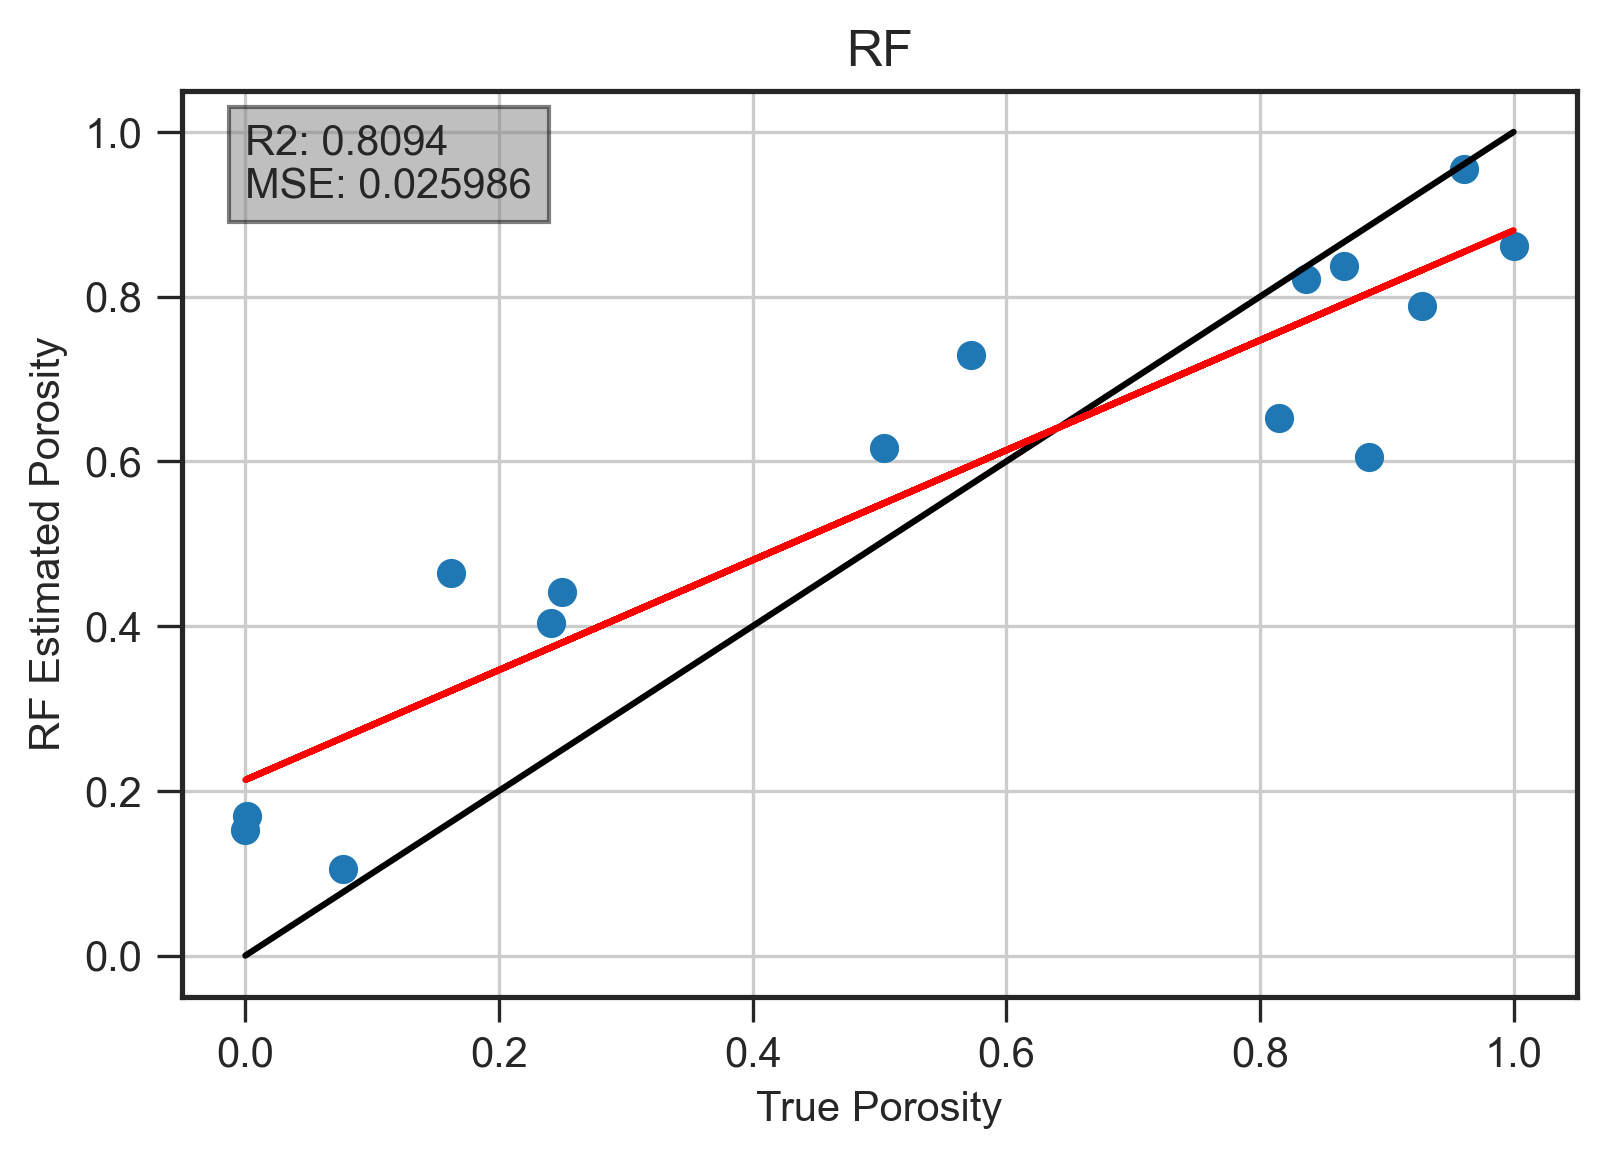

{'fit_time': array([0.04617667, 0.01700068, 0.01600003, 0.01699996, 0.01400042,
        0.01602125, 0.01599908, 0.0150001 , 0.01400399, 0.01600003,
        0.01500082, 0.01399994, 0.01500297, 0.01600003, 0.01400161]),
 'score_time': array([0.00099897, 0.00100303, 0.00099683, 0.00099969, 0.0019784 ,
        0.0010047 , 0.00099683, 0.        , 0.00099587, 0.00099969,
        0.00100207, 0.00100279, 0.0009973 , 0.        , 0.00100017]),
 'estimator': [RandomForestRegressor(n_estimators=10),
  RandomForestRegressor(n_estimators=10),
  RandomForestRegressor(n_estimators=10),
  RandomForestRegressor(n_estimators=10),
  RandomForestRegressor(n_estimators=10),
  RandomForestRegressor(n_estimators=10),
  RandomForestRegressor(n_estimators=10),
  RandomForestRegressor(n_estimators=10),
  RandomForestRegressor(n_estimators=10),
  RandomForestRegressor(n_estimators=10),
  RandomForestRegressor(n_estimators=10),
  RandomForestRegressor(n_estimators=10),
  RandomForestRegressor(n_estimators=10),
  R

In [15]:
# Random Forest
forest = RandomForestRegressor(n_estimators=10)
evaluateModel(forest, 'RF', saveBandImportances=False)

Epoch 1/600
 - 0s - loss: 0.1327 - mse: 0.1327
Epoch 2/600
 - 0s - loss: 0.1327 - mse: 0.1327
Epoch 3/600
 - 0s - loss: 0.1327 - mse: 0.1327
Epoch 4/600
 - 0s - loss: 0.1323 - mse: 0.1323
Epoch 5/600
 - 0s - loss: 0.1322 - mse: 0.1322
Epoch 6/600
 - 0s - loss: 0.1325 - mse: 0.1325
Epoch 7/600
 - 0s - loss: 0.1320 - mse: 0.1320
Epoch 8/600
 - 0s - loss: 0.1319 - mse: 0.1319
Epoch 9/600
 - 0s - loss: 0.1319 - mse: 0.1319
Epoch 10/600
 - 0s - loss: 0.1318 - mse: 0.1318
Epoch 11/600
 - 0s - loss: 0.1315 - mse: 0.1315
Epoch 12/600
 - 0s - loss: 0.1312 - mse: 0.1312
Epoch 13/600
 - 0s - loss: 0.1311 - mse: 0.1311
Epoch 14/600
 - 0s - loss: 0.1312 - mse: 0.1312
Epoch 15/600
 - 0s - loss: 0.1307 - mse: 0.1307
Epoch 16/600
 - 0s - loss: 0.1311 - mse: 0.1311
Epoch 17/600
 - 0s - loss: 0.1302 - mse: 0.1302
Epoch 18/600
 - 0s - loss: 0.1303 - mse: 0.1303
Epoch 19/600
 - 0s - loss: 0.1302 - mse: 0.1302
Epoch 20/600
 - 0s - loss: 0.1295 - mse: 0.1295
Epoch 21/600
 - 0s - loss: 0.1290 - mse: 0.1290
E

Epoch 171/600
 - 0s - loss: 0.0061 - mse: 0.0061
Epoch 172/600
 - 0s - loss: 0.0059 - mse: 0.0059
Epoch 173/600
 - 0s - loss: 0.0063 - mse: 0.0063
Epoch 174/600
 - 0s - loss: 0.0090 - mse: 0.0090
Epoch 175/600
 - 0s - loss: 0.0126 - mse: 0.0126
Epoch 176/600
 - 0s - loss: 0.0357 - mse: 0.0357
Epoch 177/600
 - 0s - loss: 0.0268 - mse: 0.0268
Epoch 178/600
 - 0s - loss: 0.0079 - mse: 0.0079
Epoch 179/600
 - 0s - loss: 0.0100 - mse: 0.0100
Epoch 180/600
 - 0s - loss: 0.0168 - mse: 0.0168
Epoch 181/600
 - 0s - loss: 0.0081 - mse: 0.0081
Epoch 182/600
 - 0s - loss: 0.0068 - mse: 0.0068
Epoch 183/600
 - 0s - loss: 0.0061 - mse: 0.0061
Epoch 184/600
 - 0s - loss: 0.0063 - mse: 0.0063
Epoch 185/600
 - 0s - loss: 0.0064 - mse: 0.0064
Epoch 186/600
 - 0s - loss: 0.0049 - mse: 0.0049
Epoch 187/600
 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 188/600
 - 0s - loss: 0.0046 - mse: 0.0046
Epoch 189/600
 - 0s - loss: 0.0045 - mse: 0.0045
Epoch 190/600
 - 0s - loss: 0.0045 - mse: 0.0045
Epoch 191/600
 - 0s 

Epoch 339/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 340/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 341/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 342/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 343/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 344/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 345/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 346/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 347/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 348/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 349/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 350/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 351/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 352/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 353/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 354/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 355/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 356/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 357/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 358/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 359/600
 - 0s 

Epoch 506/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 507/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 508/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 509/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 510/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 511/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 512/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 513/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 514/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 515/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 516/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 517/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 518/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 519/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 520/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 521/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 522/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 523/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 524/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 525/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 526/600
 - 0s 

Epoch 74/600
 - 0s - loss: 0.0376 - mse: 0.0376
Epoch 75/600
 - 0s - loss: 0.0366 - mse: 0.0366
Epoch 76/600
 - 0s - loss: 0.0355 - mse: 0.0355
Epoch 77/600
 - 0s - loss: 0.0364 - mse: 0.0364
Epoch 78/600
 - 0s - loss: 0.0367 - mse: 0.0367
Epoch 79/600
 - 0s - loss: 0.0339 - mse: 0.0339
Epoch 80/600
 - 0s - loss: 0.0311 - mse: 0.0311
Epoch 81/600
 - 0s - loss: 0.0318 - mse: 0.0318
Epoch 82/600
 - 0s - loss: 0.0308 - mse: 0.0308
Epoch 83/600
 - 0s - loss: 0.0311 - mse: 0.0311
Epoch 84/600
 - 0s - loss: 0.0309 - mse: 0.0309
Epoch 85/600
 - 0s - loss: 0.0297 - mse: 0.0297
Epoch 86/600
 - 0s - loss: 0.0280 - mse: 0.0280
Epoch 87/600
 - 0s - loss: 0.0281 - mse: 0.0281
Epoch 88/600
 - 0s - loss: 0.0269 - mse: 0.0269
Epoch 89/600
 - 0s - loss: 0.0290 - mse: 0.0290
Epoch 90/600
 - 0s - loss: 0.0279 - mse: 0.0279
Epoch 91/600
 - 0s - loss: 0.0266 - mse: 0.0266
Epoch 92/600
 - 0s - loss: 0.0255 - mse: 0.0255
Epoch 93/600
 - 0s - loss: 0.0250 - mse: 0.0250
Epoch 94/600
 - 0s - loss: 0.0241 - mse:

Epoch 242/600
 - 0s - loss: 0.0037 - mse: 0.0037
Epoch 243/600
 - 0s - loss: 0.0036 - mse: 0.0036
Epoch 244/600
 - 0s - loss: 0.0036 - mse: 0.0036
Epoch 245/600
 - 0s - loss: 0.0036 - mse: 0.0036
Epoch 246/600
 - 0s - loss: 0.0036 - mse: 0.0036
Epoch 247/600
 - 0s - loss: 0.0036 - mse: 0.0036
Epoch 248/600
 - 0s - loss: 0.0035 - mse: 0.0035
Epoch 249/600
 - 0s - loss: 0.0035 - mse: 0.0035
Epoch 250/600
 - 0s - loss: 0.0035 - mse: 0.0035
Epoch 251/600
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 252/600
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 253/600
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 254/600
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 255/600
 - 0s - loss: 0.0032 - mse: 0.0032
Epoch 256/600
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 257/600
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 258/600
 - 0s - loss: 0.0032 - mse: 0.0032
Epoch 259/600
 - 0s - loss: 0.0031 - mse: 0.0031
Epoch 260/600
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 261/600
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 262/600
 - 0s 

Epoch 410/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 411/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 412/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 413/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 414/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 415/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 416/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 417/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 418/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 419/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 420/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 421/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 422/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 423/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 424/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 425/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 426/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 427/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 428/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 429/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 430/600
 - 0s 

Epoch 573/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 574/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 575/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 576/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 577/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 578/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 579/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 580/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 581/600
 - 0s - loss: 9.7228e-04 - mse: 9.7228e-04
Epoch 582/600
 - 0s - loss: 9.6493e-04 - mse: 9.6493e-04
Epoch 583/600
 - 0s - loss: 9.9055e-04 - mse: 9.9055e-04
Epoch 584/600
 - 0s - loss: 9.5980e-04 - mse: 9.5980e-04
Epoch 585/600
 - 0s - loss: 9.8090e-04 - mse: 9.8090e-04
Epoch 586/600
 - 0s - loss: 9.6970e-04 - mse: 9.6970e-04
Epoch 587/600
 - 0s - loss: 9.7396e-04 - mse: 9.7396e-04
Epoch 588/600
 - 0s - loss: 9.8804e-04 - mse: 9.8804e-04
Epoch 589/600
 - 0s - loss: 9.5342e-04 - mse: 9.5342e-04
Epoch 590/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 591/600
 - 0s - loss: 9.2972e-04 - mse: 

Epoch 140/600
 - 0s - loss: 0.0122 - mse: 0.0122
Epoch 141/600
 - 0s - loss: 0.0137 - mse: 0.0137
Epoch 142/600
 - 0s - loss: 0.0111 - mse: 0.0111
Epoch 143/600
 - 0s - loss: 0.0112 - mse: 0.0112
Epoch 144/600
 - 0s - loss: 0.0103 - mse: 0.0103
Epoch 145/600
 - 0s - loss: 0.0100 - mse: 0.0100
Epoch 146/600
 - 0s - loss: 0.0098 - mse: 0.0098
Epoch 147/600
 - 0s - loss: 0.0095 - mse: 0.0095
Epoch 148/600
 - 0s - loss: 0.0091 - mse: 0.0091
Epoch 149/600
 - 0s - loss: 0.0090 - mse: 0.0090
Epoch 150/600
 - 0s - loss: 0.0090 - mse: 0.0090
Epoch 151/600
 - 0s - loss: 0.0089 - mse: 0.0089
Epoch 152/600
 - 0s - loss: 0.0084 - mse: 0.0084
Epoch 153/600
 - 0s - loss: 0.0084 - mse: 0.0084
Epoch 154/600
 - 0s - loss: 0.0084 - mse: 0.0084
Epoch 155/600
 - 0s - loss: 0.0085 - mse: 0.0085
Epoch 156/600
 - 0s - loss: 0.0109 - mse: 0.0109
Epoch 157/600
 - 0s - loss: 0.0159 - mse: 0.0159
Epoch 158/600
 - 0s - loss: 0.0079 - mse: 0.0079
Epoch 159/600
 - 0s - loss: 0.0079 - mse: 0.0079
Epoch 160/600
 - 0s 

Epoch 308/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 309/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 310/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 311/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 312/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 313/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 314/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 315/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 316/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 317/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 318/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 319/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 320/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 321/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 322/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 323/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 324/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 325/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 326/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 327/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 328/600
 - 0s 

Epoch 476/600
 - 0s - loss: 0.0046 - mse: 0.0046
Epoch 477/600
 - 0s - loss: 0.0038 - mse: 0.0038
Epoch 478/600
 - 0s - loss: 0.0028 - mse: 0.0028
Epoch 479/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 480/600
 - 0s - loss: 0.0030 - mse: 0.0030
Epoch 481/600
 - 0s - loss: 0.0060 - mse: 0.0060
Epoch 482/600
 - 0s - loss: 0.0044 - mse: 0.0044
Epoch 483/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 484/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 485/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 486/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 487/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 488/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 489/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 490/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 491/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 492/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 493/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 494/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 495/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 496/600
 - 0s 

Epoch 28/600
 - 0s - loss: 0.1238 - mse: 0.1238
Epoch 29/600
 - 0s - loss: 0.1225 - mse: 0.1225
Epoch 30/600
 - 0s - loss: 0.1224 - mse: 0.1224
Epoch 31/600
 - 0s - loss: 0.1209 - mse: 0.1209
Epoch 32/600
 - 0s - loss: 0.1204 - mse: 0.1204
Epoch 33/600
 - 0s - loss: 0.1189 - mse: 0.1189
Epoch 34/600
 - 0s - loss: 0.1205 - mse: 0.1205
Epoch 35/600
 - 0s - loss: 0.1179 - mse: 0.1179
Epoch 36/600
 - 0s - loss: 0.1161 - mse: 0.1161
Epoch 37/600
 - 0s - loss: 0.1165 - mse: 0.1165
Epoch 38/600
 - 0s - loss: 0.1148 - mse: 0.1148
Epoch 39/600
 - 0s - loss: 0.1123 - mse: 0.1123
Epoch 40/600
 - 0s - loss: 0.1121 - mse: 0.1121
Epoch 41/600
 - 0s - loss: 0.1145 - mse: 0.1145
Epoch 42/600
 - 0s - loss: 0.1097 - mse: 0.1097
Epoch 43/600
 - 0s - loss: 0.1068 - mse: 0.1068
Epoch 44/600
 - 0s - loss: 0.1061 - mse: 0.1061
Epoch 45/600
 - 0s - loss: 0.1022 - mse: 0.1022
Epoch 46/600
 - 0s - loss: 0.0999 - mse: 0.0999
Epoch 47/600
 - 0s - loss: 0.0977 - mse: 0.0977
Epoch 48/600
 - 0s - loss: 0.0944 - mse:

Epoch 197/600
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 198/600
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 199/600
 - 0s - loss: 0.0032 - mse: 0.0032
Epoch 200/600
 - 0s - loss: 0.0031 - mse: 0.0031
Epoch 201/600
 - 0s - loss: 0.0031 - mse: 0.0031
Epoch 202/600
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 203/600
 - 0s - loss: 0.0037 - mse: 0.0037
Epoch 204/600
 - 0s - loss: 0.0041 - mse: 0.0041
Epoch 205/600
 - 0s - loss: 0.0042 - mse: 0.0042
Epoch 206/600
 - 0s - loss: 0.0030 - mse: 0.0030
Epoch 207/600
 - 0s - loss: 0.0036 - mse: 0.0036
Epoch 208/600
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 209/600
 - 0s - loss: 0.0032 - mse: 0.0032
Epoch 210/600
 - 0s - loss: 0.0035 - mse: 0.0035
Epoch 211/600
 - 0s - loss: 0.0056 - mse: 0.0056
Epoch 212/600
 - 0s - loss: 0.0148 - mse: 0.0148
Epoch 213/600
 - 0s - loss: 0.0181 - mse: 0.0181
Epoch 214/600
 - 0s - loss: 0.0209 - mse: 0.0209
Epoch 215/600
 - 0s - loss: 0.0217 - mse: 0.0217
Epoch 216/600
 - 0s - loss: 0.0036 - mse: 0.0036
Epoch 217/600
 - 0s 

Epoch 365/600
 - 0s - loss: 9.9875e-04 - mse: 9.9875e-04
Epoch 366/600
 - 0s - loss: 9.8394e-04 - mse: 9.8394e-04
Epoch 367/600
 - 0s - loss: 9.7693e-04 - mse: 9.7693e-04
Epoch 368/600
 - 0s - loss: 9.6961e-04 - mse: 9.6961e-04
Epoch 369/600
 - 0s - loss: 9.8544e-04 - mse: 9.8544e-04
Epoch 370/600
 - 0s - loss: 9.8426e-04 - mse: 9.8426e-04
Epoch 371/600
 - 0s - loss: 9.7038e-04 - mse: 9.7038e-04
Epoch 372/600
 - 0s - loss: 9.5330e-04 - mse: 9.5330e-04
Epoch 373/600
 - 0s - loss: 9.4976e-04 - mse: 9.4976e-04
Epoch 374/600
 - 0s - loss: 9.4872e-04 - mse: 9.4872e-04
Epoch 375/600
 - 0s - loss: 9.4109e-04 - mse: 9.4109e-04
Epoch 376/600
 - 0s - loss: 9.3806e-04 - mse: 9.3806e-04
Epoch 377/600
 - 0s - loss: 9.3147e-04 - mse: 9.3147e-04
Epoch 378/600
 - 0s - loss: 9.3807e-04 - mse: 9.3807e-04
Epoch 379/600
 - 0s - loss: 9.3992e-04 - mse: 9.3992e-04
Epoch 380/600
 - 0s - loss: 9.3249e-04 - mse: 9.3249e-04
Epoch 381/600
 - 0s - loss: 9.2516e-04 - mse: 9.2516e-04
Epoch 382/600
 - 0s - loss: 9.2

Epoch 520/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 521/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 522/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 523/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 524/600
 - 0s - loss: 9.9409e-04 - mse: 9.9409e-04
Epoch 525/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 526/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 527/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 528/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 529/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 530/600
 - 0s - loss: 9.2366e-04 - mse: 9.2366e-04
Epoch 531/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 532/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 533/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 534/600
 - 0s - loss: 9.8550e-04 - mse: 9.8550e-04
Epoch 535/600
 - 0s - loss: 9.8067e-04 - mse: 9.8067e-04
Epoch 536/600
 - 0s - loss: 9.6241e-04 - mse: 9.6241e-04
Epoch 537/600
 - 0s - loss: 9.7550e-04 - mse: 9.7550e-04
Epoch 538/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 539/600
 - 0s -

Epoch 81/600
 - 0s - loss: 0.0352 - mse: 0.0352
Epoch 82/600
 - 0s - loss: 0.0340 - mse: 0.0340
Epoch 83/600
 - 0s - loss: 0.0331 - mse: 0.0331
Epoch 84/600
 - 0s - loss: 0.0323 - mse: 0.0323
Epoch 85/600
 - 0s - loss: 0.0321 - mse: 0.0321
Epoch 86/600
 - 0s - loss: 0.0310 - mse: 0.0310
Epoch 87/600
 - 0s - loss: 0.0307 - mse: 0.0307
Epoch 88/600
 - 0s - loss: 0.0306 - mse: 0.0306
Epoch 89/600
 - 0s - loss: 0.0292 - mse: 0.0292
Epoch 90/600
 - 0s - loss: 0.0286 - mse: 0.0286
Epoch 91/600
 - 0s - loss: 0.0273 - mse: 0.0273
Epoch 92/600
 - 0s - loss: 0.0276 - mse: 0.0276
Epoch 93/600
 - 0s - loss: 0.0260 - mse: 0.0260
Epoch 94/600
 - 0s - loss: 0.0273 - mse: 0.0273
Epoch 95/600
 - 0s - loss: 0.0279 - mse: 0.0279
Epoch 96/600
 - 0s - loss: 0.0264 - mse: 0.0264
Epoch 97/600
 - 0s - loss: 0.0259 - mse: 0.0259
Epoch 98/600
 - 0s - loss: 0.0239 - mse: 0.0239
Epoch 99/600
 - 0s - loss: 0.0233 - mse: 0.0233
Epoch 100/600
 - 0s - loss: 0.0226 - mse: 0.0226
Epoch 101/600
 - 0s - loss: 0.0235 - ms

Epoch 249/600
 - 0s - loss: 0.0075 - mse: 0.0075
Epoch 250/600
 - 0s - loss: 0.0118 - mse: 0.0118
Epoch 251/600
 - 0s - loss: 0.0252 - mse: 0.0252
Epoch 252/600
 - 0s - loss: 0.0278 - mse: 0.0278
Epoch 253/600
 - 0s - loss: 0.0230 - mse: 0.0230
Epoch 254/600
 - 0s - loss: 0.0457 - mse: 0.0457
Epoch 255/600
 - 0s - loss: 0.0152 - mse: 0.0152
Epoch 256/600
 - 0s - loss: 0.0167 - mse: 0.0167
Epoch 257/600
 - 0s - loss: 0.0126 - mse: 0.0126
Epoch 258/600
 - 0s - loss: 0.0081 - mse: 0.0081
Epoch 259/600
 - 0s - loss: 0.0078 - mse: 0.0078
Epoch 260/600
 - 0s - loss: 0.0077 - mse: 0.0077
Epoch 261/600
 - 0s - loss: 0.0104 - mse: 0.0104
Epoch 262/600
 - 0s - loss: 0.0072 - mse: 0.0072
Epoch 263/600
 - 0s - loss: 0.0051 - mse: 0.0051
Epoch 264/600
 - 0s - loss: 0.0064 - mse: 0.0064
Epoch 265/600
 - 0s - loss: 0.0052 - mse: 0.0052
Epoch 266/600
 - 0s - loss: 0.0096 - mse: 0.0096
Epoch 267/600
 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 268/600
 - 0s - loss: 0.0043 - mse: 0.0043
Epoch 269/600
 - 0s 

Epoch 417/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 418/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 419/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 420/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 421/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 422/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 423/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 424/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 425/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 426/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 427/600
 - 0s - loss: 0.0016 - mse: 0.0016
Epoch 428/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 429/600
 - 0s - loss: 0.0016 - mse: 0.0016
Epoch 430/600
 - 0s - loss: 0.0024 - mse: 0.0024
Epoch 431/600
 - 0s - loss: 0.0046 - mse: 0.0046
Epoch 432/600
 - 0s - loss: 0.0023 - mse: 0.0023
Epoch 433/600
 - 0s - loss: 0.0017 - mse: 0.0017
Epoch 434/600
 - 0s - loss: 0.0016 - mse: 0.0016
Epoch 435/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 436/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 437/600
 - 0s 

Epoch 576/600
 - 0s - loss: 8.3325e-04 - mse: 8.3325e-04
Epoch 577/600
 - 0s - loss: 8.1017e-04 - mse: 8.1017e-04
Epoch 578/600
 - 0s - loss: 8.1058e-04 - mse: 8.1058e-04
Epoch 579/600
 - 0s - loss: 8.0091e-04 - mse: 8.0091e-04
Epoch 580/600
 - 0s - loss: 8.0290e-04 - mse: 8.0290e-04
Epoch 581/600
 - 0s - loss: 7.9565e-04 - mse: 7.9565e-04
Epoch 582/600
 - 0s - loss: 7.9755e-04 - mse: 7.9755e-04
Epoch 583/600
 - 0s - loss: 7.9747e-04 - mse: 7.9747e-04
Epoch 584/600
 - 0s - loss: 8.0201e-04 - mse: 8.0201e-04
Epoch 585/600
 - 0s - loss: 8.0367e-04 - mse: 8.0367e-04
Epoch 586/600
 - 0s - loss: 7.9039e-04 - mse: 7.9039e-04
Epoch 587/600
 - 0s - loss: 7.7750e-04 - mse: 7.7750e-04
Epoch 588/600
 - 0s - loss: 7.7891e-04 - mse: 7.7891e-04
Epoch 589/600
 - 0s - loss: 7.7667e-04 - mse: 7.7667e-04
Epoch 590/600
 - 0s - loss: 7.7066e-04 - mse: 7.7066e-04
Epoch 591/600
 - 0s - loss: 7.6879e-04 - mse: 7.6879e-04
Epoch 592/600
 - 0s - loss: 7.6448e-04 - mse: 7.6448e-04
Epoch 593/600
 - 0s - loss: 7.6

Epoch 142/600
 - 0s - loss: 0.0077 - mse: 0.0077
Epoch 143/600
 - 0s - loss: 0.0076 - mse: 0.0076
Epoch 144/600
 - 0s - loss: 0.0075 - mse: 0.0075
Epoch 145/600
 - 0s - loss: 0.0074 - mse: 0.0074
Epoch 146/600
 - 0s - loss: 0.0073 - mse: 0.0073
Epoch 147/600
 - 0s - loss: 0.0072 - mse: 0.0072
Epoch 148/600
 - 0s - loss: 0.0071 - mse: 0.0071
Epoch 149/600
 - 0s - loss: 0.0070 - mse: 0.0070
Epoch 150/600
 - 0s - loss: 0.0069 - mse: 0.0069
Epoch 151/600
 - 0s - loss: 0.0067 - mse: 0.0067
Epoch 152/600
 - 0s - loss: 0.0067 - mse: 0.0067
Epoch 153/600
 - 0s - loss: 0.0066 - mse: 0.0066
Epoch 154/600
 - 0s - loss: 0.0065 - mse: 0.0065
Epoch 155/600
 - 0s - loss: 0.0064 - mse: 0.0064
Epoch 156/600
 - 0s - loss: 0.0063 - mse: 0.0063
Epoch 157/600
 - 0s - loss: 0.0062 - mse: 0.0062
Epoch 158/600
 - 0s - loss: 0.0061 - mse: 0.0061
Epoch 159/600
 - 0s - loss: 0.0061 - mse: 0.0061
Epoch 160/600
 - 0s - loss: 0.0060 - mse: 0.0060
Epoch 161/600
 - 0s - loss: 0.0060 - mse: 0.0060
Epoch 162/600
 - 0s 

Epoch 310/600
 - 0s - loss: 0.0085 - mse: 0.0085
Epoch 311/600
 - 0s - loss: 0.0062 - mse: 0.0062
Epoch 312/600
 - 0s - loss: 0.0050 - mse: 0.0050
Epoch 313/600
 - 0s - loss: 0.0039 - mse: 0.0039
Epoch 314/600
 - 0s - loss: 0.0032 - mse: 0.0032
Epoch 315/600
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 316/600
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 317/600
 - 0s - loss: 0.0093 - mse: 0.0093
Epoch 318/600
 - 0s - loss: 0.0037 - mse: 0.0037
Epoch 319/600
 - 0s - loss: 0.0028 - mse: 0.0028
Epoch 320/600
 - 0s - loss: 0.0025 - mse: 0.0025
Epoch 321/600
 - 0s - loss: 0.0025 - mse: 0.0025
Epoch 322/600
 - 0s - loss: 0.0040 - mse: 0.0040
Epoch 323/600
 - 0s - loss: 0.0030 - mse: 0.0030
Epoch 324/600
 - 0s - loss: 0.0026 - mse: 0.0026
Epoch 325/600
 - 0s - loss: 0.0025 - mse: 0.0025
Epoch 326/600
 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 327/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 328/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 329/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 330/600
 - 0s 

Epoch 477/600
 - 0s - loss: 9.2320e-04 - mse: 9.2320e-04
Epoch 478/600
 - 0s - loss: 9.5795e-04 - mse: 9.5795e-04
Epoch 479/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 480/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 481/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 482/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 483/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 484/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 485/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 486/600
 - 0s - loss: 9.8940e-04 - mse: 9.8940e-04
Epoch 487/600
 - 0s - loss: 9.8743e-04 - mse: 9.8743e-04
Epoch 488/600
 - 0s - loss: 9.8480e-04 - mse: 9.8480e-04
Epoch 489/600
 - 0s - loss: 9.1837e-04 - mse: 9.1837e-04
Epoch 490/600
 - 0s - loss: 9.2226e-04 - mse: 9.2226e-04
Epoch 491/600
 - 0s - loss: 9.3524e-04 - mse: 9.3524e-04
Epoch 492/600
 - 0s - loss: 9.0657e-04 - mse: 9.0657e-04
Epoch 493/600
 - 0s - loss: 9.7313e-04 - mse: 9.7313e-04
Epoch 494/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 495/600
 - 0s - loss: 9.7285e-04

Epoch 31/600
 - 0s - loss: 0.1172 - mse: 0.1172
Epoch 32/600
 - 0s - loss: 0.1163 - mse: 0.1163
Epoch 33/600
 - 0s - loss: 0.1150 - mse: 0.1150
Epoch 34/600
 - 0s - loss: 0.1149 - mse: 0.1149
Epoch 35/600
 - 0s - loss: 0.1137 - mse: 0.1137
Epoch 36/600
 - 0s - loss: 0.1118 - mse: 0.1118
Epoch 37/600
 - 0s - loss: 0.1108 - mse: 0.1108
Epoch 38/600
 - 0s - loss: 0.1100 - mse: 0.1100
Epoch 39/600
 - 0s - loss: 0.1084 - mse: 0.1084
Epoch 40/600
 - 0s - loss: 0.1085 - mse: 0.1085
Epoch 41/600
 - 0s - loss: 0.1077 - mse: 0.1077
Epoch 42/600
 - 0s - loss: 0.1054 - mse: 0.1054
Epoch 43/600
 - 0s - loss: 0.1035 - mse: 0.1035
Epoch 44/600
 - 0s - loss: 0.1030 - mse: 0.1030
Epoch 45/600
 - 0s - loss: 0.1067 - mse: 0.1067
Epoch 46/600
 - 0s - loss: 0.1010 - mse: 0.1010
Epoch 47/600
 - 0s - loss: 0.1000 - mse: 0.1000
Epoch 48/600
 - 0s - loss: 0.0997 - mse: 0.0997
Epoch 49/600
 - 0s - loss: 0.0981 - mse: 0.0981
Epoch 50/600
 - 0s - loss: 0.0975 - mse: 0.0975
Epoch 51/600
 - 0s - loss: 0.0962 - mse:

Epoch 200/600
 - 0s - loss: 0.0256 - mse: 0.0256
Epoch 201/600
 - 0s - loss: 0.0258 - mse: 0.0258
Epoch 202/600
 - 0s - loss: 0.0255 - mse: 0.0255
Epoch 203/600
 - 0s - loss: 0.0252 - mse: 0.0252
Epoch 204/600
 - 0s - loss: 0.0251 - mse: 0.0251
Epoch 205/600
 - 0s - loss: 0.0249 - mse: 0.0249
Epoch 206/600
 - 0s - loss: 0.0247 - mse: 0.0247
Epoch 207/600
 - 0s - loss: 0.0244 - mse: 0.0244
Epoch 208/600
 - 0s - loss: 0.0244 - mse: 0.0244
Epoch 209/600
 - 0s - loss: 0.0242 - mse: 0.0242
Epoch 210/600
 - 0s - loss: 0.0238 - mse: 0.0238
Epoch 211/600
 - 0s - loss: 0.0238 - mse: 0.0238
Epoch 212/600
 - 0s - loss: 0.0238 - mse: 0.0238
Epoch 213/600
 - 0s - loss: 0.0233 - mse: 0.0233
Epoch 214/600
 - 0s - loss: 0.0233 - mse: 0.0233
Epoch 215/600
 - 0s - loss: 0.0240 - mse: 0.0240
Epoch 216/600
 - 0s - loss: 0.0229 - mse: 0.0229
Epoch 217/600
 - 0s - loss: 0.0229 - mse: 0.0229
Epoch 218/600
 - 0s - loss: 0.0224 - mse: 0.0224
Epoch 219/600
 - 0s - loss: 0.0223 - mse: 0.0223
Epoch 220/600
 - 0s 

Epoch 368/600
 - 0s - loss: 0.0104 - mse: 0.0104
Epoch 369/600
 - 0s - loss: 0.0099 - mse: 0.0099
Epoch 370/600
 - 0s - loss: 0.0099 - mse: 0.0099
Epoch 371/600
 - 0s - loss: 0.0098 - mse: 0.0098
Epoch 372/600
 - 0s - loss: 0.0102 - mse: 0.0102
Epoch 373/600
 - 0s - loss: 0.0114 - mse: 0.0114
Epoch 374/600
 - 0s - loss: 0.0093 - mse: 0.0093
Epoch 375/600
 - 0s - loss: 0.0096 - mse: 0.0096
Epoch 376/600
 - 0s - loss: 0.0093 - mse: 0.0093
Epoch 377/600
 - 0s - loss: 0.0088 - mse: 0.0088
Epoch 378/600
 - 0s - loss: 0.0091 - mse: 0.0091
Epoch 379/600
 - 0s - loss: 0.0086 - mse: 0.0086
Epoch 380/600
 - 0s - loss: 0.0090 - mse: 0.0090
Epoch 381/600
 - 0s - loss: 0.0088 - mse: 0.0088
Epoch 382/600
 - 0s - loss: 0.0083 - mse: 0.0083
Epoch 383/600
 - 0s - loss: 0.0084 - mse: 0.0084
Epoch 384/600
 - 0s - loss: 0.0082 - mse: 0.0082
Epoch 385/600
 - 0s - loss: 0.0082 - mse: 0.0082
Epoch 386/600
 - 0s - loss: 0.0081 - mse: 0.0081
Epoch 387/600
 - 0s - loss: 0.0081 - mse: 0.0081
Epoch 388/600
 - 0s 

 - 0s - loss: 0.0054 - mse: 0.0054
Epoch 536/600
 - 0s - loss: 0.0096 - mse: 0.0096
Epoch 537/600
 - 0s - loss: 0.0089 - mse: 0.0089
Epoch 538/600
 - 0s - loss: 0.0049 - mse: 0.0049
Epoch 539/600
 - 0s - loss: 0.0057 - mse: 0.0057
Epoch 540/600
 - 0s - loss: 0.0049 - mse: 0.0049
Epoch 541/600
 - 0s - loss: 0.0042 - mse: 0.0042
Epoch 542/600
 - 0s - loss: 0.0045 - mse: 0.0045
Epoch 543/600
 - 0s - loss: 0.0050 - mse: 0.0050
Epoch 544/600
 - 0s - loss: 0.0065 - mse: 0.0065
Epoch 545/600
 - 0s - loss: 0.0043 - mse: 0.0043
Epoch 546/600
 - 0s - loss: 0.0080 - mse: 0.0080
Epoch 547/600
 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 548/600
 - 0s - loss: 0.0044 - mse: 0.0044
Epoch 549/600
 - 0s - loss: 0.0041 - mse: 0.0041
Epoch 550/600
 - 0s - loss: 0.0042 - mse: 0.0042
Epoch 551/600
 - 0s - loss: 0.0038 - mse: 0.0038
Epoch 552/600
 - 0s - loss: 0.0038 - mse: 0.0038
Epoch 553/600
 - 0s - loss: 0.0037 - mse: 0.0037
Epoch 554/600
 - 0s - loss: 0.0038 - mse: 0.0038
Epoch 555/600
 - 0s - loss: 0.0038

Epoch 105/600
 - 0s - loss: 0.0172 - mse: 0.0172
Epoch 106/600
 - 0s - loss: 0.0172 - mse: 0.0172
Epoch 107/600
 - 0s - loss: 0.0166 - mse: 0.0166
Epoch 108/600
 - 0s - loss: 0.0160 - mse: 0.0160
Epoch 109/600
 - 0s - loss: 0.0159 - mse: 0.0159
Epoch 110/600
 - 0s - loss: 0.0154 - mse: 0.0154
Epoch 111/600
 - 0s - loss: 0.0144 - mse: 0.0144
Epoch 112/600
 - 0s - loss: 0.0151 - mse: 0.0151
Epoch 113/600
 - 0s - loss: 0.0138 - mse: 0.0138
Epoch 114/600
 - 0s - loss: 0.0165 - mse: 0.0165
Epoch 115/600
 - 0s - loss: 0.0145 - mse: 0.0145
Epoch 116/600
 - 0s - loss: 0.0176 - mse: 0.0176
Epoch 117/600
 - 0s - loss: 0.0146 - mse: 0.0146
Epoch 118/600
 - 0s - loss: 0.0149 - mse: 0.0149
Epoch 119/600
 - 0s - loss: 0.0128 - mse: 0.0128
Epoch 120/600
 - 0s - loss: 0.0125 - mse: 0.0125
Epoch 121/600
 - 0s - loss: 0.0131 - mse: 0.0131
Epoch 122/600
 - 0s - loss: 0.0122 - mse: 0.0122
Epoch 123/600
 - 0s - loss: 0.0112 - mse: 0.0112
Epoch 124/600
 - 0s - loss: 0.0112 - mse: 0.0112
Epoch 125/600
 - 0s 

Epoch 273/600
 - 0s - loss: 0.0017 - mse: 0.0017
Epoch 274/600
 - 0s - loss: 0.0017 - mse: 0.0017
Epoch 275/600
 - 0s - loss: 0.0017 - mse: 0.0017
Epoch 276/600
 - 0s - loss: 0.0017 - mse: 0.0017
Epoch 277/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 278/600
 - 0s - loss: 0.0017 - mse: 0.0017
Epoch 279/600
 - 0s - loss: 0.0017 - mse: 0.0017
Epoch 280/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 281/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 282/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 283/600
 - 0s - loss: 0.0023 - mse: 0.0023
Epoch 284/600
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 285/600
 - 0s - loss: 0.0099 - mse: 0.0099
Epoch 286/600
 - 0s - loss: 0.0065 - mse: 0.0065
Epoch 287/600
 - 0s - loss: 0.0056 - mse: 0.0056
Epoch 288/600
 - 0s - loss: 0.0053 - mse: 0.0053
Epoch 289/600
 - 0s - loss: 0.0100 - mse: 0.0100
Epoch 290/600
 - 0s - loss: 0.0058 - mse: 0.0058
Epoch 291/600
 - 0s - loss: 0.0048 - mse: 0.0048
Epoch 292/600
 - 0s - loss: 0.0056 - mse: 0.0056
Epoch 293/600
 - 0s 

Epoch 432/600
 - 0s - loss: 9.4033e-04 - mse: 9.4033e-04
Epoch 433/600
 - 0s - loss: 9.8568e-04 - mse: 9.8568e-04
Epoch 434/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 435/600
 - 0s - loss: 9.6207e-04 - mse: 9.6207e-04
Epoch 436/600
 - 0s - loss: 8.9203e-04 - mse: 8.9203e-04
Epoch 437/600
 - 0s - loss: 8.5925e-04 - mse: 8.5925e-04
Epoch 438/600
 - 0s - loss: 8.4168e-04 - mse: 8.4168e-04
Epoch 439/600
 - 0s - loss: 8.2152e-04 - mse: 8.2152e-04
Epoch 440/600
 - 0s - loss: 7.9086e-04 - mse: 7.9086e-04
Epoch 441/600
 - 0s - loss: 7.7684e-04 - mse: 7.7684e-04
Epoch 442/600
 - 0s - loss: 7.6799e-04 - mse: 7.6799e-04
Epoch 443/600
 - 0s - loss: 7.7139e-04 - mse: 7.7139e-04
Epoch 444/600
 - 0s - loss: 7.4239e-04 - mse: 7.4239e-04
Epoch 445/600
 - 0s - loss: 7.3822e-04 - mse: 7.3822e-04
Epoch 446/600
 - 0s - loss: 7.2725e-04 - mse: 7.2725e-04
Epoch 447/600
 - 0s - loss: 7.3461e-04 - mse: 7.3461e-04
Epoch 448/600
 - 0s - loss: 7.1759e-04 - mse: 7.1759e-04
Epoch 449/600
 - 0s - loss: 6.5708e-04 

Epoch 581/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 582/600
 - 0s - loss: 0.0016 - mse: 0.0016
Epoch 583/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 584/600
 - 0s - loss: 0.0024 - mse: 0.0024
Epoch 585/600
 - 0s - loss: 0.0016 - mse: 0.0016
Epoch 586/600
 - 0s - loss: 0.0036 - mse: 0.0036
Epoch 587/600
 - 0s - loss: 0.0023 - mse: 0.0023
Epoch 588/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 589/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 590/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 591/600
 - 0s - loss: 0.0024 - mse: 0.0024
Epoch 592/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 593/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 594/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 595/600
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 596/600
 - 0s - loss: 0.0026 - mse: 0.0026
Epoch 597/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 598/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 599/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 600/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 1/600
 - 0s - 

Epoch 151/600
 - 0s - loss: 0.0070 - mse: 0.0070
Epoch 152/600
 - 0s - loss: 0.0067 - mse: 0.0067
Epoch 153/600
 - 0s - loss: 0.0067 - mse: 0.0067
Epoch 154/600
 - 0s - loss: 0.0066 - mse: 0.0066
Epoch 155/600
 - 0s - loss: 0.0065 - mse: 0.0065
Epoch 156/600
 - 0s - loss: 0.0064 - mse: 0.0064
Epoch 157/600
 - 0s - loss: 0.0063 - mse: 0.0063
Epoch 158/600
 - 0s - loss: 0.0062 - mse: 0.0062
Epoch 159/600
 - 0s - loss: 0.0060 - mse: 0.0060
Epoch 160/600
 - 0s - loss: 0.0061 - mse: 0.0061
Epoch 161/600
 - 0s - loss: 0.0060 - mse: 0.0060
Epoch 162/600
 - 0s - loss: 0.0059 - mse: 0.0059
Epoch 163/600
 - 0s - loss: 0.0057 - mse: 0.0057
Epoch 164/600
 - 0s - loss: 0.0058 - mse: 0.0058
Epoch 165/600
 - 0s - loss: 0.0056 - mse: 0.0056
Epoch 166/600
 - 0s - loss: 0.0055 - mse: 0.0055
Epoch 167/600
 - 0s - loss: 0.0055 - mse: 0.0055
Epoch 168/600
 - 0s - loss: 0.0054 - mse: 0.0054
Epoch 169/600
 - 0s - loss: 0.0054 - mse: 0.0054
Epoch 170/600
 - 0s - loss: 0.0053 - mse: 0.0053
Epoch 171/600
 - 0s 

Epoch 319/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 320/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 321/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 322/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 323/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 324/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 325/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 326/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 327/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 328/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 329/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 330/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 331/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 332/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 333/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 334/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 335/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 336/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 337/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 338/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 339/600
 - 0s 

Epoch 486/600
 - 0s - loss: 9.4209e-04 - mse: 9.4209e-04
Epoch 487/600
 - 0s - loss: 9.4937e-04 - mse: 9.4937e-04
Epoch 488/600
 - 0s - loss: 9.8401e-04 - mse: 9.8401e-04
Epoch 489/600
 - 0s - loss: 9.7267e-04 - mse: 9.7267e-04
Epoch 490/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 491/600
 - 0s - loss: 9.1244e-04 - mse: 9.1244e-04
Epoch 492/600
 - 0s - loss: 8.9159e-04 - mse: 8.9159e-04
Epoch 493/600
 - 0s - loss: 8.8401e-04 - mse: 8.8401e-04
Epoch 494/600
 - 0s - loss: 8.7298e-04 - mse: 8.7298e-04
Epoch 495/600
 - 0s - loss: 8.6309e-04 - mse: 8.6309e-04
Epoch 496/600
 - 0s - loss: 8.7229e-04 - mse: 8.7229e-04
Epoch 497/600
 - 0s - loss: 8.4822e-04 - mse: 8.4822e-04
Epoch 498/600
 - 0s - loss: 8.6867e-04 - mse: 8.6867e-04
Epoch 499/600
 - 0s - loss: 8.9749e-04 - mse: 8.9749e-04
Epoch 500/600
 - 0s - loss: 8.4914e-04 - mse: 8.4914e-04
Epoch 501/600
 - 0s - loss: 8.7747e-04 - mse: 8.7747e-04
Epoch 502/600
 - 0s - loss: 8.6012e-04 - mse: 8.6012e-04
Epoch 503/600
 - 0s - loss: 8.8676e-04 

Epoch 39/600
 - 0s - loss: 0.1234 - mse: 0.1234
Epoch 40/600
 - 0s - loss: 0.1241 - mse: 0.1241
Epoch 41/600
 - 0s - loss: 0.1215 - mse: 0.1215
Epoch 42/600
 - 0s - loss: 0.1193 - mse: 0.1193
Epoch 43/600
 - 0s - loss: 0.1175 - mse: 0.1175
Epoch 44/600
 - 0s - loss: 0.1152 - mse: 0.1152
Epoch 45/600
 - 0s - loss: 0.1136 - mse: 0.1136
Epoch 46/600
 - 0s - loss: 0.1121 - mse: 0.1121
Epoch 47/600
 - 0s - loss: 0.1107 - mse: 0.1107
Epoch 48/600
 - 0s - loss: 0.1102 - mse: 0.1102
Epoch 49/600
 - 0s - loss: 0.1113 - mse: 0.1113
Epoch 50/600
 - 0s - loss: 0.1057 - mse: 0.1057
Epoch 51/600
 - 0s - loss: 0.1021 - mse: 0.1021
Epoch 52/600
 - 0s - loss: 0.0991 - mse: 0.0991
Epoch 53/600
 - 0s - loss: 0.0975 - mse: 0.0975
Epoch 54/600
 - 0s - loss: 0.0957 - mse: 0.0957
Epoch 55/600
 - 0s - loss: 0.0932 - mse: 0.0932
Epoch 56/600
 - 0s - loss: 0.0939 - mse: 0.0939
Epoch 57/600
 - 0s - loss: 0.0898 - mse: 0.0898
Epoch 58/600
 - 0s - loss: 0.0866 - mse: 0.0866
Epoch 59/600
 - 0s - loss: 0.0843 - mse:

Epoch 208/600
 - 0s - loss: 0.0040 - mse: 0.0040
Epoch 209/600
 - 0s - loss: 0.0040 - mse: 0.0040
Epoch 210/600
 - 0s - loss: 0.0039 - mse: 0.0039
Epoch 211/600
 - 0s - loss: 0.0039 - mse: 0.0039
Epoch 212/600
 - 0s - loss: 0.0038 - mse: 0.0038
Epoch 213/600
 - 0s - loss: 0.0038 - mse: 0.0038
Epoch 214/600
 - 0s - loss: 0.0038 - mse: 0.0038
Epoch 215/600
 - 0s - loss: 0.0037 - mse: 0.0037
Epoch 216/600
 - 0s - loss: 0.0037 - mse: 0.0037
Epoch 217/600
 - 0s - loss: 0.0037 - mse: 0.0037
Epoch 218/600
 - 0s - loss: 0.0036 - mse: 0.0036
Epoch 219/600
 - 0s - loss: 0.0036 - mse: 0.0036
Epoch 220/600
 - 0s - loss: 0.0036 - mse: 0.0036
Epoch 221/600
 - 0s - loss: 0.0035 - mse: 0.0035
Epoch 222/600
 - 0s - loss: 0.0035 - mse: 0.0035
Epoch 223/600
 - 0s - loss: 0.0035 - mse: 0.0035
Epoch 224/600
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 225/600
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 226/600
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 227/600
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 228/600
 - 0s 

 - 0s - loss: 0.0127 - mse: 0.0127
Epoch 376/600
 - 0s - loss: 0.0030 - mse: 0.0030
Epoch 377/600
 - 0s - loss: 0.0030 - mse: 0.0030
Epoch 378/600
 - 0s - loss: 0.0045 - mse: 0.0045
Epoch 379/600
 - 0s - loss: 0.0037 - mse: 0.0037
Epoch 380/600
 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 381/600
 - 0s - loss: 0.0027 - mse: 0.0027
Epoch 382/600
 - 0s - loss: 0.0023 - mse: 0.0023
Epoch 383/600
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 384/600
 - 0s - loss: 0.0024 - mse: 0.0024
Epoch 385/600
 - 0s - loss: 0.0027 - mse: 0.0027
Epoch 386/600
 - 0s - loss: 0.0023 - mse: 0.0023
Epoch 387/600
 - 0s - loss: 0.0045 - mse: 0.0045
Epoch 388/600
 - 0s - loss: 0.0056 - mse: 0.0056
Epoch 389/600
 - 0s - loss: 0.0031 - mse: 0.0031
Epoch 390/600
 - 0s - loss: 0.0025 - mse: 0.0025
Epoch 391/600
 - 0s - loss: 0.0026 - mse: 0.0026
Epoch 392/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 393/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 394/600
 - 0s - loss: 0.0017 - mse: 0.0017
Epoch 395/600
 - 0s - loss: 0.0017

Epoch 534/600
 - 0s - loss: 4.7409e-04 - mse: 4.7409e-04
Epoch 535/600
 - 0s - loss: 4.6612e-04 - mse: 4.6612e-04
Epoch 536/600
 - 0s - loss: 4.6678e-04 - mse: 4.6678e-04
Epoch 537/600
 - 0s - loss: 4.6104e-04 - mse: 4.6104e-04
Epoch 538/600
 - 0s - loss: 4.5695e-04 - mse: 4.5695e-04
Epoch 539/600
 - 0s - loss: 4.5469e-04 - mse: 4.5469e-04
Epoch 540/600
 - 0s - loss: 4.5317e-04 - mse: 4.5317e-04
Epoch 541/600
 - 0s - loss: 4.5333e-04 - mse: 4.5333e-04
Epoch 542/600
 - 0s - loss: 4.4854e-04 - mse: 4.4854e-04
Epoch 543/600
 - 0s - loss: 4.6404e-04 - mse: 4.6403e-04
Epoch 544/600
 - 0s - loss: 4.7326e-04 - mse: 4.7326e-04
Epoch 545/600
 - 0s - loss: 4.8273e-04 - mse: 4.8273e-04
Epoch 546/600
 - 0s - loss: 5.2789e-04 - mse: 5.2789e-04
Epoch 547/600
 - 0s - loss: 5.4406e-04 - mse: 5.4406e-04
Epoch 548/600
 - 0s - loss: 6.2090e-04 - mse: 6.2090e-04
Epoch 549/600
 - 0s - loss: 5.3568e-04 - mse: 5.3568e-04
Epoch 550/600
 - 0s - loss: 5.2554e-04 - mse: 5.2554e-04
Epoch 551/600
 - 0s - loss: 5.1

Epoch 94/600
 - 0s - loss: 0.0209 - mse: 0.0209
Epoch 95/600
 - 0s - loss: 0.0205 - mse: 0.0205
Epoch 96/600
 - 0s - loss: 0.0210 - mse: 0.0210
Epoch 97/600
 - 0s - loss: 0.0187 - mse: 0.0187
Epoch 98/600
 - 0s - loss: 0.0191 - mse: 0.0191
Epoch 99/600
 - 0s - loss: 0.0186 - mse: 0.0186
Epoch 100/600
 - 0s - loss: 0.0167 - mse: 0.0167
Epoch 101/600
 - 0s - loss: 0.0178 - mse: 0.0178
Epoch 102/600
 - 0s - loss: 0.0177 - mse: 0.0177
Epoch 103/600
 - 0s - loss: 0.0156 - mse: 0.0156
Epoch 104/600
 - 0s - loss: 0.0155 - mse: 0.0155
Epoch 105/600
 - 0s - loss: 0.0157 - mse: 0.0157
Epoch 106/600
 - 0s - loss: 0.0186 - mse: 0.0186
Epoch 107/600
 - 0s - loss: 0.0183 - mse: 0.0183
Epoch 108/600
 - 0s - loss: 0.0145 - mse: 0.0145
Epoch 109/600
 - 0s - loss: 0.0145 - mse: 0.0145
Epoch 110/600
 - 0s - loss: 0.0164 - mse: 0.0164
Epoch 111/600
 - 0s - loss: 0.0131 - mse: 0.0131
Epoch 112/600
 - 0s - loss: 0.0126 - mse: 0.0126
Epoch 113/600
 - 0s - loss: 0.0133 - mse: 0.0133
Epoch 114/600
 - 0s - loss

Epoch 262/600
 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 263/600
 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 264/600
 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 265/600
 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 266/600
 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 267/600
 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 268/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 269/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 270/600
 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 271/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 272/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 273/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 274/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 275/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 276/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 277/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 278/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 279/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 280/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 281/600
 - 0s - loss: 0.0022 - mse: 0.0022
Epoch 282/600
 - 0s 

 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 430/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 431/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 432/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 433/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 434/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 435/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 436/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 437/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 438/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 439/600
 - 0s - loss: 9.9720e-04 - mse: 9.9720e-04
Epoch 440/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 441/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 442/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 443/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 444/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 445/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 446/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 447/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 448/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 449/600
 - 0s - loss

Epoch 592/600
 - 0s - loss: 8.6521e-04 - mse: 8.6521e-04
Epoch 593/600
 - 0s - loss: 8.6061e-04 - mse: 8.6061e-04
Epoch 594/600
 - 0s - loss: 8.5236e-04 - mse: 8.5236e-04
Epoch 595/600
 - 0s - loss: 8.4988e-04 - mse: 8.4988e-04
Epoch 596/600
 - 0s - loss: 8.5123e-04 - mse: 8.5123e-04
Epoch 597/600
 - 0s - loss: 8.4821e-04 - mse: 8.4821e-04
Epoch 598/600
 - 0s - loss: 8.4682e-04 - mse: 8.4682e-04
Epoch 599/600
 - 0s - loss: 8.6011e-04 - mse: 8.6011e-04
Epoch 600/600
 - 0s - loss: 9.9728e-04 - mse: 9.9729e-04
Epoch 1/600
 - 0s - loss: 0.1313 - mse: 0.1313
Epoch 2/600
 - 0s - loss: 0.1306 - mse: 0.1306
Epoch 3/600
 - 0s - loss: 0.1297 - mse: 0.1297
Epoch 4/600
 - 0s - loss: 0.1296 - mse: 0.1296
Epoch 5/600
 - 0s - loss: 0.1286 - mse: 0.1286
Epoch 6/600
 - 0s - loss: 0.1278 - mse: 0.1278
Epoch 7/600
 - 0s - loss: 0.1273 - mse: 0.1273
Epoch 8/600
 - 0s - loss: 0.1270 - mse: 0.1270
Epoch 9/600
 - 0s - loss: 0.1267 - mse: 0.1267
Epoch 10/600
 - 0s - loss: 0.1257 - mse: 0.1257
Epoch 11/600
 - 

Epoch 160/600
 - 0s - loss: 0.0090 - mse: 0.0090
Epoch 161/600
 - 0s - loss: 0.0087 - mse: 0.0087
Epoch 162/600
 - 0s - loss: 0.0087 - mse: 0.0087
Epoch 163/600
 - 0s - loss: 0.0084 - mse: 0.0084
Epoch 164/600
 - 0s - loss: 0.0086 - mse: 0.0086
Epoch 165/600
 - 0s - loss: 0.0087 - mse: 0.0087
Epoch 166/600
 - 0s - loss: 0.0087 - mse: 0.0087
Epoch 167/600
 - 0s - loss: 0.0082 - mse: 0.0082
Epoch 168/600
 - 0s - loss: 0.0080 - mse: 0.0080
Epoch 169/600
 - 0s - loss: 0.0078 - mse: 0.0078
Epoch 170/600
 - 0s - loss: 0.0077 - mse: 0.0077
Epoch 171/600
 - 0s - loss: 0.0075 - mse: 0.0075
Epoch 172/600
 - 0s - loss: 0.0074 - mse: 0.0074
Epoch 173/600
 - 0s - loss: 0.0074 - mse: 0.0074
Epoch 174/600
 - 0s - loss: 0.0073 - mse: 0.0073
Epoch 175/600
 - 0s - loss: 0.0072 - mse: 0.0072
Epoch 176/600
 - 0s - loss: 0.0071 - mse: 0.0071
Epoch 177/600
 - 0s - loss: 0.0071 - mse: 0.0071
Epoch 178/600
 - 0s - loss: 0.0069 - mse: 0.0069
Epoch 179/600
 - 0s - loss: 0.0068 - mse: 0.0068
Epoch 180/600
 - 0s 

Epoch 328/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 329/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 330/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 331/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 332/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 333/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 334/600
 - 0s - loss: 0.0020 - mse: 0.0020
Epoch 335/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 336/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 337/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 338/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 339/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 340/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 341/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 342/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 343/600
 - 0s - loss: 0.0018 - mse: 0.0018
Epoch 344/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 345/600
 - 0s - loss: 0.0021 - mse: 0.0021
Epoch 346/600
 - 0s - loss: 0.0023 - mse: 0.0023
Epoch 347/600
 - 0s - loss: 0.0025 - mse: 0.0025
Epoch 348/600
 - 0s 

Epoch 494/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 495/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 496/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 497/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 498/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 499/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 500/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 501/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 502/600
 - 0s - loss: 0.0012 - mse: 0.0012
Epoch 503/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 504/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 505/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 506/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 507/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 508/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 509/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 510/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 511/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 512/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 513/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 514/600
 - 0s 

Epoch 50/600
 - 0s - loss: 0.0832 - mse: 0.0832
Epoch 51/600
 - 0s - loss: 0.0802 - mse: 0.0802
Epoch 52/600
 - 0s - loss: 0.0772 - mse: 0.0772
Epoch 53/600
 - 0s - loss: 0.0759 - mse: 0.0759
Epoch 54/600
 - 0s - loss: 0.0773 - mse: 0.0773
Epoch 55/600
 - 0s - loss: 0.0846 - mse: 0.0846
Epoch 56/600
 - 0s - loss: 0.0888 - mse: 0.0888
Epoch 57/600
 - 0s - loss: 0.0726 - mse: 0.0726
Epoch 58/600
 - 0s - loss: 0.0744 - mse: 0.0744
Epoch 59/600
 - 0s - loss: 0.0651 - mse: 0.0651
Epoch 60/600
 - 0s - loss: 0.0623 - mse: 0.0623
Epoch 61/600
 - 0s - loss: 0.0615 - mse: 0.0615
Epoch 62/600
 - 0s - loss: 0.0569 - mse: 0.0569
Epoch 63/600
 - 0s - loss: 0.0558 - mse: 0.0558
Epoch 64/600
 - 0s - loss: 0.0532 - mse: 0.0532
Epoch 65/600
 - 0s - loss: 0.0521 - mse: 0.0521
Epoch 66/600
 - 0s - loss: 0.0503 - mse: 0.0503
Epoch 67/600
 - 0s - loss: 0.0488 - mse: 0.0488
Epoch 68/600
 - 0s - loss: 0.0474 - mse: 0.0474
Epoch 69/600
 - 0s - loss: 0.0460 - mse: 0.0460
Epoch 70/600
 - 0s - loss: 0.0446 - mse:

Epoch 219/600
 - 0s - loss: 0.0035 - mse: 0.0035
Epoch 220/600
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 221/600
 - 0s - loss: 0.0034 - mse: 0.0034
Epoch 222/600
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 223/600
 - 0s - loss: 0.0033 - mse: 0.0033
Epoch 224/600
 - 0s - loss: 0.0032 - mse: 0.0032
Epoch 225/600
 - 0s - loss: 0.0032 - mse: 0.0032
Epoch 226/600
 - 0s - loss: 0.0032 - mse: 0.0032
Epoch 227/600
 - 0s - loss: 0.0031 - mse: 0.0031
Epoch 228/600
 - 0s - loss: 0.0031 - mse: 0.0031
Epoch 229/600
 - 0s - loss: 0.0030 - mse: 0.0030
Epoch 230/600
 - 0s - loss: 0.0030 - mse: 0.0030
Epoch 231/600
 - 0s - loss: 0.0030 - mse: 0.0030
Epoch 232/600
 - 0s - loss: 0.0030 - mse: 0.0030
Epoch 233/600
 - 0s - loss: 0.0030 - mse: 0.0030
Epoch 234/600
 - 0s - loss: 0.0030 - mse: 0.0030
Epoch 235/600
 - 0s - loss: 0.0029 - mse: 0.0029
Epoch 236/600
 - 0s - loss: 0.0028 - mse: 0.0028
Epoch 237/600
 - 0s - loss: 0.0028 - mse: 0.0028
Epoch 238/600
 - 0s - loss: 0.0028 - mse: 0.0028
Epoch 239/600
 - 0s 

Epoch 385/600
 - 0s - loss: 9.5815e-04 - mse: 9.5815e-04
Epoch 386/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 387/600
 - 0s - loss: 9.3738e-04 - mse: 9.3738e-04
Epoch 388/600
 - 0s - loss: 8.9456e-04 - mse: 8.9456e-04
Epoch 389/600
 - 0s - loss: 9.3173e-04 - mse: 9.3173e-04
Epoch 390/600
 - 0s - loss: 8.7438e-04 - mse: 8.7438e-04
Epoch 391/600
 - 0s - loss: 8.9250e-04 - mse: 8.9250e-04
Epoch 392/600
 - 0s - loss: 8.8343e-04 - mse: 8.8343e-04
Epoch 393/600
 - 0s - loss: 8.8508e-04 - mse: 8.8508e-04
Epoch 394/600
 - 0s - loss: 8.9867e-04 - mse: 8.9867e-04
Epoch 395/600
 - 0s - loss: 9.1779e-04 - mse: 9.1779e-04
Epoch 396/600
 - 0s - loss: 9.0137e-04 - mse: 9.0137e-04
Epoch 397/600
 - 0s - loss: 8.8956e-04 - mse: 8.8956e-04
Epoch 398/600
 - 0s - loss: 9.7020e-04 - mse: 9.7020e-04
Epoch 399/600
 - 0s - loss: 8.8681e-04 - mse: 8.8681e-04
Epoch 400/600
 - 0s - loss: 8.9874e-04 - mse: 8.9874e-04
Epoch 401/600
 - 0s - loss: 8.9767e-04 - mse: 8.9767e-04
Epoch 402/600
 - 0s - loss: 0.0010 - ms

Epoch 535/600
 - 0s - loss: 8.2037e-04 - mse: 8.2037e-04
Epoch 536/600
 - 0s - loss: 7.9162e-04 - mse: 7.9162e-04
Epoch 537/600
 - 0s - loss: 8.0993e-04 - mse: 8.0993e-04
Epoch 538/600
 - 0s - loss: 9.5112e-04 - mse: 9.5112e-04
Epoch 539/600
 - 0s - loss: 9.1020e-04 - mse: 9.1020e-04
Epoch 540/600
 - 0s - loss: 8.5805e-04 - mse: 8.5805e-04
Epoch 541/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 542/600
 - 0s - loss: 7.9446e-04 - mse: 7.9446e-04
Epoch 543/600
 - 0s - loss: 6.8850e-04 - mse: 6.8850e-04
Epoch 544/600
 - 0s - loss: 8.2538e-04 - mse: 8.2538e-04
Epoch 545/600
 - 0s - loss: 6.8696e-04 - mse: 6.8696e-04
Epoch 546/600
 - 0s - loss: 8.0656e-04 - mse: 8.0656e-04
Epoch 547/600
 - 0s - loss: 8.2865e-04 - mse: 8.2865e-04
Epoch 548/600
 - 0s - loss: 6.7571e-04 - mse: 6.7571e-04
Epoch 549/600
 - 0s - loss: 7.6404e-04 - mse: 7.6404e-04
Epoch 550/600
 - 0s - loss: 7.0482e-04 - mse: 7.0482e-04
Epoch 551/600
 - 0s - loss: 7.2748e-04 - mse: 7.2748e-04
Epoch 552/600
 - 0s - loss: 7.4296e-04 

Epoch 96/600
 - 0s - loss: 0.0483 - mse: 0.0483
Epoch 97/600
 - 0s - loss: 0.0478 - mse: 0.0478
Epoch 98/600
 - 0s - loss: 0.0473 - mse: 0.0473
Epoch 99/600
 - 0s - loss: 0.0469 - mse: 0.0469
Epoch 100/600
 - 0s - loss: 0.0463 - mse: 0.0463
Epoch 101/600
 - 0s - loss: 0.0459 - mse: 0.0459
Epoch 102/600
 - 0s - loss: 0.0454 - mse: 0.0454
Epoch 103/600
 - 0s - loss: 0.0451 - mse: 0.0451
Epoch 104/600
 - 0s - loss: 0.0447 - mse: 0.0447
Epoch 105/600
 - 0s - loss: 0.0444 - mse: 0.0444
Epoch 106/600
 - 0s - loss: 0.0441 - mse: 0.0441
Epoch 107/600
 - 0s - loss: 0.0435 - mse: 0.0435
Epoch 108/600
 - 0s - loss: 0.0429 - mse: 0.0429
Epoch 109/600
 - 0s - loss: 0.0425 - mse: 0.0425
Epoch 110/600
 - 0s - loss: 0.0421 - mse: 0.0421
Epoch 111/600
 - 0s - loss: 0.0418 - mse: 0.0418
Epoch 112/600
 - 0s - loss: 0.0417 - mse: 0.0417
Epoch 113/600
 - 0s - loss: 0.0420 - mse: 0.0420
Epoch 114/600
 - 0s - loss: 0.0432 - mse: 0.0432
Epoch 115/600
 - 0s - loss: 0.0597 - mse: 0.0597
Epoch 116/600
 - 0s - lo

 - 0s - loss: 0.0144 - mse: 0.0144
Epoch 264/600
 - 0s - loss: 0.0138 - mse: 0.0138
Epoch 265/600
 - 0s - loss: 0.0140 - mse: 0.0140
Epoch 266/600
 - 0s - loss: 0.0134 - mse: 0.0134
Epoch 267/600
 - 0s - loss: 0.0135 - mse: 0.0135
Epoch 268/600
 - 0s - loss: 0.0135 - mse: 0.0135
Epoch 269/600
 - 0s - loss: 0.0136 - mse: 0.0136
Epoch 270/600
 - 0s - loss: 0.0131 - mse: 0.0131
Epoch 271/600
 - 0s - loss: 0.0136 - mse: 0.0136
Epoch 272/600
 - 0s - loss: 0.0127 - mse: 0.0127
Epoch 273/600
 - 0s - loss: 0.0129 - mse: 0.0129
Epoch 274/600
 - 0s - loss: 0.0132 - mse: 0.0132
Epoch 275/600
 - 0s - loss: 0.0127 - mse: 0.0127
Epoch 276/600
 - 0s - loss: 0.0125 - mse: 0.0125
Epoch 277/600
 - 0s - loss: 0.0124 - mse: 0.0124
Epoch 278/600
 - 0s - loss: 0.0125 - mse: 0.0125
Epoch 279/600
 - 0s - loss: 0.0124 - mse: 0.0124
Epoch 280/600
 - 0s - loss: 0.0121 - mse: 0.0121
Epoch 281/600
 - 0s - loss: 0.0120 - mse: 0.0120
Epoch 282/600
 - 0s - loss: 0.0123 - mse: 0.0123
Epoch 283/600
 - 0s - loss: 0.0123

Epoch 431/600
 - 0s - loss: 0.0043 - mse: 0.0043
Epoch 432/600
 - 0s - loss: 0.0042 - mse: 0.0042
Epoch 433/600
 - 0s - loss: 0.0042 - mse: 0.0042
Epoch 434/600
 - 0s - loss: 0.0042 - mse: 0.0042
Epoch 435/600
 - 0s - loss: 0.0044 - mse: 0.0044
Epoch 436/600
 - 0s - loss: 0.0043 - mse: 0.0043
Epoch 437/600
 - 0s - loss: 0.0044 - mse: 0.0044
Epoch 438/600
 - 0s - loss: 0.0043 - mse: 0.0043
Epoch 439/600
 - 0s - loss: 0.0041 - mse: 0.0041
Epoch 440/600
 - 0s - loss: 0.0041 - mse: 0.0041
Epoch 441/600
 - 0s - loss: 0.0042 - mse: 0.0042
Epoch 442/600
 - 0s - loss: 0.0041 - mse: 0.0041
Epoch 443/600
 - 0s - loss: 0.0040 - mse: 0.0040
Epoch 444/600
 - 0s - loss: 0.0042 - mse: 0.0042
Epoch 445/600
 - 0s - loss: 0.0045 - mse: 0.0045
Epoch 446/600
 - 0s - loss: 0.0049 - mse: 0.0049
Epoch 447/600
 - 0s - loss: 0.0047 - mse: 0.0047
Epoch 448/600
 - 0s - loss: 0.0051 - mse: 0.0051
Epoch 449/600
 - 0s - loss: 0.0044 - mse: 0.0044
Epoch 450/600
 - 0s - loss: 0.0043 - mse: 0.0043
Epoch 451/600
 - 0s 

 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 599/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 600/600
 - 0s - loss: 0.0019 - mse: 0.0019
Epoch 1/600
 - 0s - loss: 0.1477 - mse: 0.1477
Epoch 2/600
 - 0s - loss: 0.1473 - mse: 0.1473
Epoch 3/600
 - 0s - loss: 0.1472 - mse: 0.1472
Epoch 4/600
 - 0s - loss: 0.1470 - mse: 0.1470
Epoch 5/600
 - 0s - loss: 0.1467 - mse: 0.1467
Epoch 6/600
 - 0s - loss: 0.1464 - mse: 0.1464
Epoch 7/600
 - 0s - loss: 0.1461 - mse: 0.1461
Epoch 8/600
 - 0s - loss: 0.1459 - mse: 0.1459
Epoch 9/600
 - 0s - loss: 0.1456 - mse: 0.1456
Epoch 10/600
 - 0s - loss: 0.1455 - mse: 0.1455
Epoch 11/600
 - 0s - loss: 0.1451 - mse: 0.1451
Epoch 12/600
 - 0s - loss: 0.1449 - mse: 0.1449
Epoch 13/600
 - 0s - loss: 0.1445 - mse: 0.1445
Epoch 14/600
 - 0s - loss: 0.1441 - mse: 0.1441
Epoch 15/600
 - 0s - loss: 0.1438 - mse: 0.1438
Epoch 16/600
 - 0s - loss: 0.1433 - mse: 0.1433
Epoch 17/600
 - 0s - loss: 0.1431 - mse: 0.1431
Epoch 18/600
 - 0s - loss: 0.1423 - mse: 0.1423
Epoch 19/600

Epoch 168/600
 - 0s - loss: 0.0078 - mse: 0.0078
Epoch 169/600
 - 0s - loss: 0.0068 - mse: 0.0068
Epoch 170/600
 - 0s - loss: 0.0065 - mse: 0.0065
Epoch 171/600
 - 0s - loss: 0.0063 - mse: 0.0063
Epoch 172/600
 - 0s - loss: 0.0061 - mse: 0.0061
Epoch 173/600
 - 0s - loss: 0.0060 - mse: 0.0060
Epoch 174/600
 - 0s - loss: 0.0059 - mse: 0.0059
Epoch 175/600
 - 0s - loss: 0.0059 - mse: 0.0059
Epoch 176/600
 - 0s - loss: 0.0058 - mse: 0.0058
Epoch 177/600
 - 0s - loss: 0.0057 - mse: 0.0057
Epoch 178/600
 - 0s - loss: 0.0057 - mse: 0.0057
Epoch 179/600
 - 0s - loss: 0.0056 - mse: 0.0056
Epoch 180/600
 - 0s - loss: 0.0055 - mse: 0.0055
Epoch 181/600
 - 0s - loss: 0.0055 - mse: 0.0055
Epoch 182/600
 - 0s - loss: 0.0054 - mse: 0.0054
Epoch 183/600
 - 0s - loss: 0.0053 - mse: 0.0053
Epoch 184/600
 - 0s - loss: 0.0053 - mse: 0.0053
Epoch 185/600
 - 0s - loss: 0.0052 - mse: 0.0052
Epoch 186/600
 - 0s - loss: 0.0052 - mse: 0.0052
Epoch 187/600
 - 0s - loss: 0.0051 - mse: 0.0051
Epoch 188/600
 - 0s 

 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 336/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 337/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 338/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 339/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 340/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 341/600
 - 0s - loss: 0.0017 - mse: 0.0017
Epoch 342/600
 - 0s - loss: 0.0016 - mse: 0.0016
Epoch 343/600
 - 0s - loss: 0.0017 - mse: 0.0017
Epoch 344/600
 - 0s - loss: 0.0016 - mse: 0.0016
Epoch 345/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 346/600
 - 0s - loss: 0.0015 - mse: 0.0015
Epoch 347/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 348/600
 - 0s - loss: 0.0014 - mse: 0.0014
Epoch 349/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 350/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 351/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 352/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 353/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 354/600
 - 0s - loss: 0.0013 - mse: 0.0013
Epoch 355/600
 - 0s - loss: 0.0013

Epoch 496/600
 - 0s - loss: 8.8677e-04 - mse: 8.8677e-04
Epoch 497/600
 - 0s - loss: 8.8622e-04 - mse: 8.8622e-04
Epoch 498/600
 - 0s - loss: 9.1459e-04 - mse: 9.1459e-04
Epoch 499/600
 - 0s - loss: 9.1404e-04 - mse: 9.1404e-04
Epoch 500/600
 - 0s - loss: 8.7258e-04 - mse: 8.7258e-04
Epoch 501/600
 - 0s - loss: 8.8018e-04 - mse: 8.8018e-04
Epoch 502/600
 - 0s - loss: 9.2464e-04 - mse: 9.2464e-04
Epoch 503/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 504/600
 - 0s - loss: 9.1676e-04 - mse: 9.1676e-04
Epoch 505/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 506/600
 - 0s - loss: 0.0010 - mse: 0.0010
Epoch 507/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 508/600
 - 0s - loss: 0.0011 - mse: 0.0011
Epoch 509/600
 - 0s - loss: 9.7766e-04 - mse: 9.7766e-04
Epoch 510/600
 - 0s - loss: 9.1121e-04 - mse: 9.1121e-04
Epoch 511/600
 - 0s - loss: 9.2769e-04 - mse: 9.2768e-04
Epoch 512/600
 - 0s - loss: 9.0874e-04 - mse: 9.0874e-04
Epoch 513/600
 - 0s - loss: 9.2538e-04 - mse: 9.2538e-04
Epoch 514/600


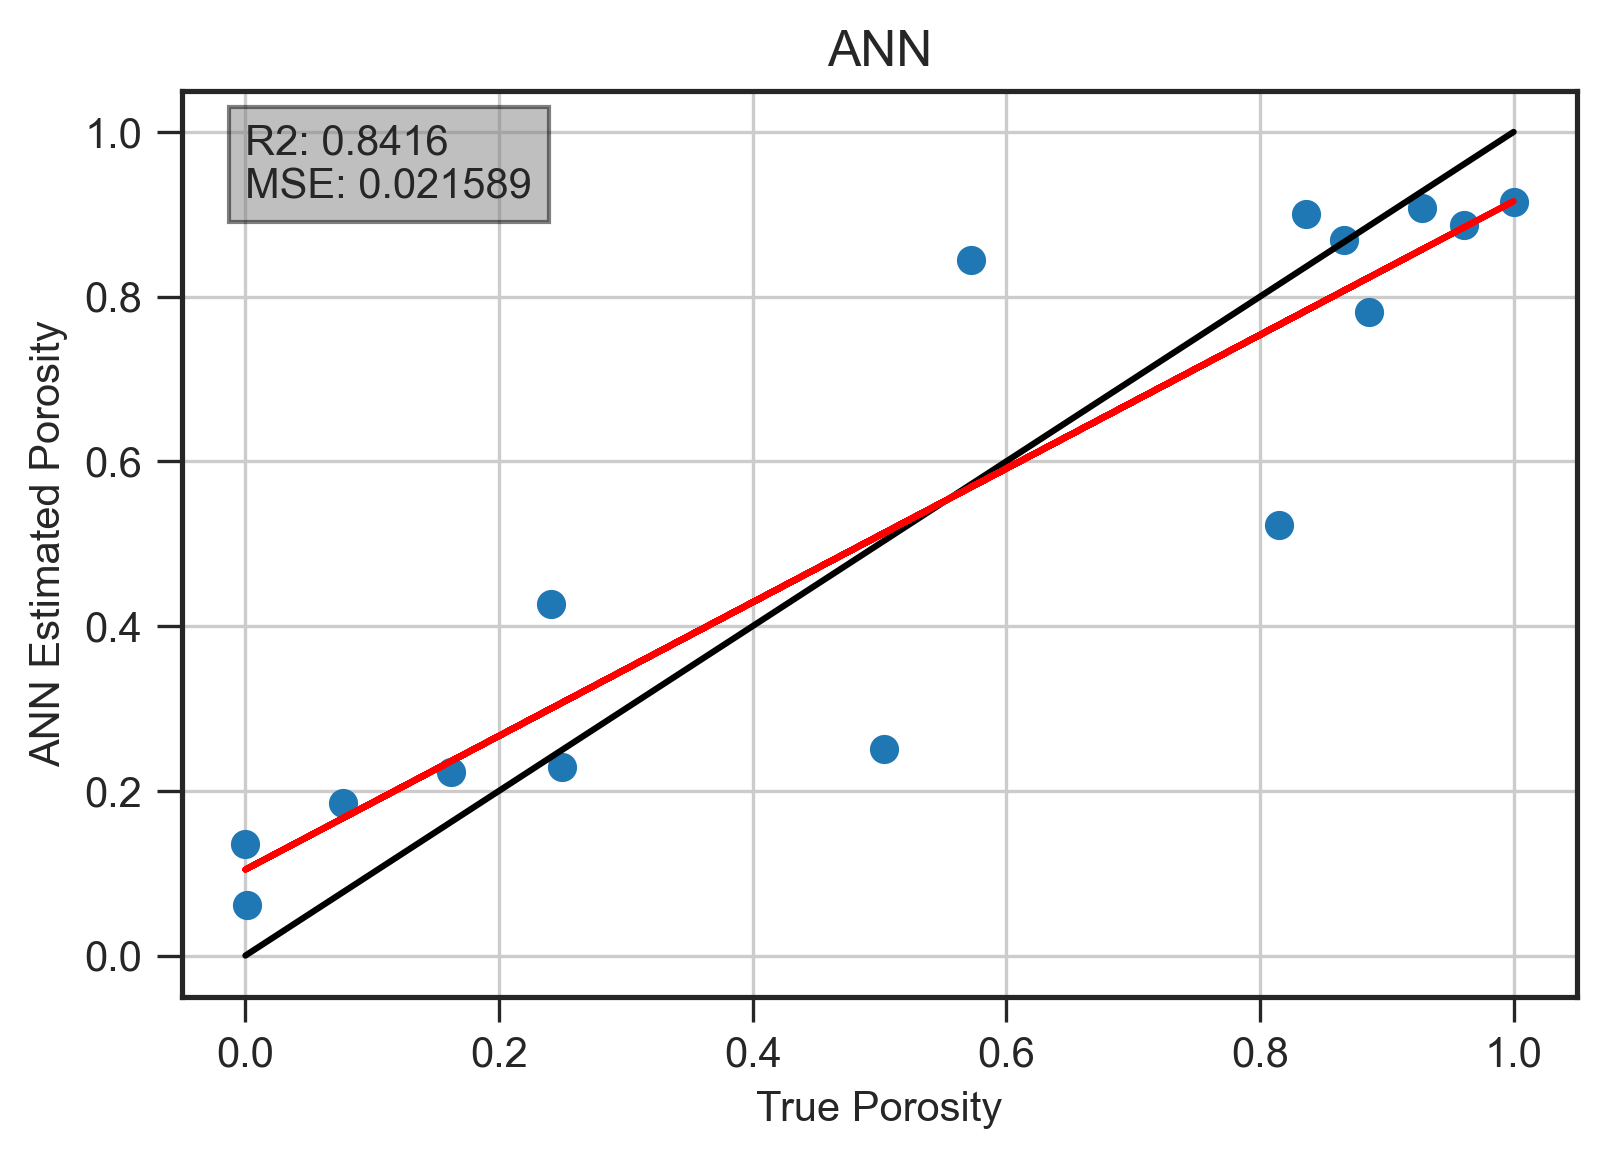

{'fit_time': array([19.77643895, 19.29765105, 19.56103158, 19.22314429, 19.05452275,
        19.44134879, 19.32886505, 19.66782236, 19.77054858, 19.76180625,
        19.96871471, 19.16445637, 19.08899975, 20.7283752 , 20.06443214]),
 'score_time': array([0.01800156, 0.01904917, 0.01800156, 0.0170362 , 0.01701045,
        0.01804757, 0.02200127, 0.01822257, 0.01699972, 0.01900077,
        0.01900077, 0.01799965, 0.01799941, 0.1530025 , 0.01801085]),
 'estimator': [<keras.wrappers.scikit_learn.KerasRegressor at 0x19b16042b08>,
 'test_mse': array([-5.50507361e-03, -7.41511537e-02, -4.29518207e-06, -7.20088021e-03,
        -4.33192173e-04, -3.45234399e-02, -1.17407702e-02, -1.09744054e-02,
        -3.69105749e-03, -8.55663357e-02, -3.96105156e-04, -3.57058289e-03,
        -4.00138604e-03, -1.84795541e-02, -6.35926922e-02])}

In [18]:
# ANN Model Evaluation

def buildANN():
  c = Sequential()               
  c.add(Dense(units = 8,
              kernel_initializer = 'uniform',
              activation = 'sigmoid', 
              input_dim = len(XComplete[0,:])))
  c.add(Dense(units = 8, 
              kernel_initializer = 'uniform',
              activation = 'sigmoid'))
  c.add(Dense(units = 1, kernel_initializer = 'uniform',
              activation = 'sigmoid'))
  c.compile(optimizer = 'adam',
          loss = 'mean_squared_error', 
          metrics=['mse'])
  return c

ann = keras.wrappers.scikit_learn.KerasRegressor(buildANN, 
                                                 epochs=600, 
                                                 batch_size = 1, 
                                                 verbose=2)
evaluateModel(ann, 'ANN', saveBandImportances=False)